# 1. Import Data and Python Packages

In [1]:
# Dependencies and setup
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit, RandomizedSearchCV, cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.compose import ColumnTransformer
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
import statsmodels.api as sm
from sklearn.tree import plot_tree
import os
%matplotlib inline

In [2]:
# Set maximum rows to a high number
pd.set_option('display.max_rows', 100)

In [3]:
# Load datasets
training_data = pd.read_csv('01-raw_data/train.csv',index_col=0)
testing_data = pd.read_csv('01-raw_data/test.csv',index_col=0)

# 2. Perform Initial Observations and Deal with Missing Values

### 2a. Investigate shape of dataset and whether or not there are any missing values

In [4]:
# Make copies of the original DataFrames in order to prevent errors
training_data_2 = training_data.copy()
testing_data_2 = testing_data.copy()

In [5]:
# Investigate shape of the training dataset
training_data_2.shape

(891, 11)

In [6]:
# Investigate shape of the testing dataset
testing_data_2.shape

(418, 10)

In [7]:
# Investigate missing values in the training dataset
total_missing_training = training_data_2.isnull().sum().sort_values (ascending = False)
percent_missing_training = round((training_data_2.isnull().sum().sort_values(ascending = False)/len(training_data_2))*100,2)
pd.concat([total_missing_training, percent_missing_training], axis = 1, keys = ['Total','Percent'])

,Total,Percent
Cabin,687,77.10
Age,177,19.87
Embarked,2,0.22
Fare,0,0.00
Ticket,0,0.00
Parch,0,0.00
SibSp,0,0.00
Sex,0,0.00
Name,0,0.00
Pclass,0,0.00


In [8]:
# Investigate missing values in the testing dataset
total_missing_testing = testing_data_2.isnull().sum().sort_values (ascending = False)
percent_missing_testing = round((testing_data_2.isnull().sum().sort_values(ascending = False)/len(testing_data_2))*100,2)
pd.concat([total_missing_testing, percent_missing_testing], axis = 1, keys = ['Total','Percent'])

,Total,Percent
Cabin,327,78.23
Age,86,20.57
Fare,1,0.24
Embarked,0,0.00
Ticket,0,0.00
Parch,0,0.00
SibSp,0,0.00
Sex,0,0.00
Name,0,0.00
Pclass,0,0.00


The training dataset has 11 columns and 891 observations. The testing dataset has 10 columns and 418 observations. The training dataset includes whether or not the passenger survived while the testing dataset does not.

There are missing values in the 'Cabin', 'Age', 'Embarked', and 'Fare' columns. It is important to figure out a way to deal with these missing values so that machine learning algorithms will work.

### 2b. Dealing with 'Fare' missing values

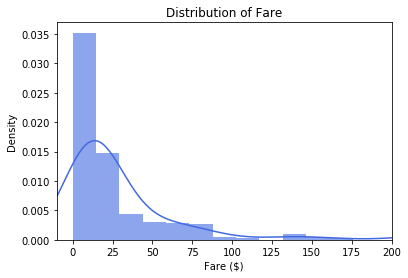

In [9]:
# Plot a histogram of fares in the training dataset
testing_data_2.Fare.hist(bins=35, density = True, stacked = True, alpha = 0.6, color='royalblue')
testing_data_2.Fare.plot(kind = 'density', color = 'royalblue')
plt.xlabel('Fare ($)')
plt.xlim(-10,200)
plt.title('Distribution of Fare')
plt.show()

In [10]:
# Look at the line item with the missing Fare value
testing_data_2[testing_data_2['Fare'].isnull()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [11]:
# Fill in missing Fare values with the median Fare paid by customers of the same passenger class, sex, and port of embarkation
testing_data_2['Fare'] = testing_data_2.groupby(['Pclass','Sex','Embarked'])['Fare'].transform(lambda x: x.fillna(x.median()))

One 'Fare' value is missing from the test dataset. Since the nature of this problem is figuring out guesses for whether or not the 418 individuals in the testing dataset survived, a line item cannot be removed from the testing dataset. Replacing the missing 'Fare' value is the best option. 

The 'Fare' variable is right skewed so it's best to replace this variable with a median value rather than an average value. Replacing the missing Fare value with the median of the group of individuals who have the same ticket class, sex, and who embarked from the same port, ensures that the missing 'Fare' value is replaced with a 'Fare' value from a similar passenger.

### 2c. Dealing with 'Embarked' missing values

In [12]:
# Look into what the 'Embarked' null rows look like
training_data_2[training_data_2['Embarked'].isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [13]:
# Check if there are any other passengers with the same ticket number
training_data_2[training_data_2['Ticket']=='113572']

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [14]:
# Check if there are any other passengers with the same ticket number
testing_data_2[testing_data_2['Ticket']=='113572']

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,


In [15]:
# Check if there are any other passengers with the same Cabin
training_data_2[training_data_2['Cabin']=='B28']

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [16]:
# Check if there are any other passengers with the same Cabin
testing_data_2[testing_data_2['Cabin']=='B28']

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,


In [17]:
# Look at the percentiles of fare prices paid for all first ticket class women
training_data_2[(training_data_2['Pclass'] == 1) & (training_data_2['Sex'] == 'female')].groupby('Embarked')['Fare'].describe()

,count,mean,std,min,25%,50%,75%,max
Embarked,,,,,,,,
C,43.0,115.640309,88.571645,27.7208,69.3,83.1583,134.500000,512.3292
Q,1.0,90.000000,NaN,90.0000,90.0,90.0000,90.000000,90.0000
S,48.0,99.026910,61.094407,25.9292,53.1,79.6500,139.612475,263.0000


In [18]:
# Look into the most port of embarkation for people on cabin level B
training_data_2[training_data_2['Cabin'].str[0]=='B']['Embarked'].value_counts()

S    23
C    22
Name: Embarked, dtype: int64

In [19]:
# Look at what ticket class individuals on the same cabin level tend to be
training_data_2[training_data_2['Cabin'].str[0]=='B']['Pclass'].value_counts()

1    47
Name: Pclass, dtype: int64

In [20]:
# Look at what gender people tend to be on cabin level B 
training_data_2[training_data_2['Cabin'].str[0]=='B']['Sex'].value_counts()

female    27
male      20
Name: Sex, dtype: int64

In [21]:
# Look at the percentiles of fare prices paid for women on cabin level B
training_data_2[(training_data_2['Cabin'].str[0]=='B') & (training_data_2['Sex'] == 'female')].groupby('Embarked')['Fare'].describe()

,count,mean,std,min,25%,50%,75%,max
Embarked,,,,,,,,
C,12.0,124.014233,87.994021,27.7208,57.9792,80.1896,171.7708,262.3750
S,13.0,113.731731,60.386313,30.0000,86.5000,93.5000,120.0000,211.3375


In [22]:
# Replace the missing 'Embarked' datapoints with 'C' for 'Cherbourg'
training_data_2.update(training_data_2['Embarked'].fillna('C'))

Both of the people who have the their port of embarkation missing paid a fare of 80 dollars to board the ship. Both of these individuals are women, with the same ticket class, ticket number, and cabin number. Both women are first class passengers who resided on cabin floor B.

No other passengers have the same ticket number of cabin number as the passengers with the missing port of embarkation value.

First, I look at what price other first class women paid to board the titanic and found that passengers who embarked in 'Cherbourg' and 'Southampton' tended to pay similar prices to both of these women.

Then, I investigated the cabin floor that both of these women were residing in (cabin floor B) and found that passengers with their cabins identified as being on floor B all have first class tickets and embarked from either 'Cherbourg' or 'Southampton'.

The fares that the two women with missing port of embarkation variables paid were most similar to those of first class women residing in cabin floor B who embarked from 'Cherbourg'. Therefore, it's best to replace the null port of embarkation values with 'C' for 'Cherbourg'.

### 2d. Dealing with 'Age' missing values

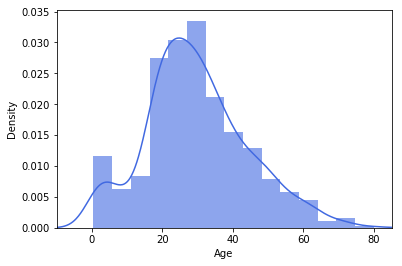

In [23]:
# Plot a histogram of ages in the training dataset
training_data_2.Age.hist(bins=15, density = True, stacked = True, alpha = 0.6, color='royalblue')
training_data_2.Age.plot(kind = 'density', color = 'royalblue')
plt.xlabel('Age')
plt.xlim(-10,85)
plt.show()

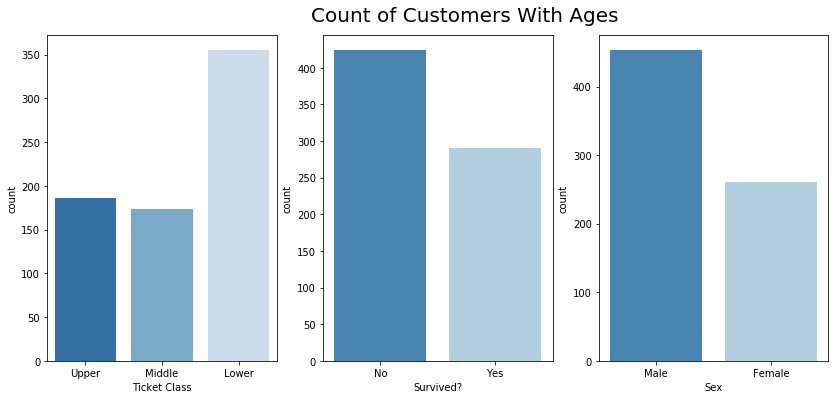

In [24]:
# Set up the figure with two subplots
fig, (axis1,axis2,axis3) = plt.subplots(1, 3, figsize=(14,6))
# Create a plot showing the count of observations with upper, middle, and lower classes
sns.countplot(x = 'Pclass', data = training_data_2[training_data_2.Age.notnull()], palette = 'Blues_r', ax = axis1)
axis1.set_xticklabels(['Upper','Middle','Lower'])
axis1.set_xlabel('Ticket Class')
# Create a plot showing the proportion of people in each class who survived
sns.countplot(x = 'Survived', data = training_data_2[training_data_2.Age.notnull()], palette = 'Blues_r', ax = axis2)
axis2.set_xticklabels(['No','Yes'])
axis2.set_xlabel('Survived?')
# Create a plot showing the proportion of people in each class who survived
sns.countplot(x = 'Sex', data = training_data_2[training_data_2.Age.notnull()], palette = 'Blues_r', ax = axis3)
axis3.set_xticklabels(['Male','Female'])
axis3.set_xlabel('Sex')

plt.text(-3, 495, 'Count of Customers With Ages', fontsize = 20)
plt.show()

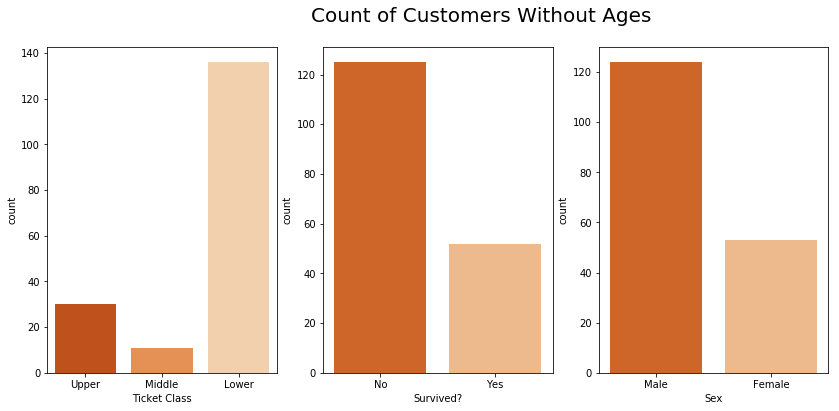

In [25]:
# Set up the figure with two subplots
fig, (axis1,axis2,axis3) = plt.subplots(1, 3, figsize=(14,6))
# Create a plot showing the count of observations with upper, middle, and lower classes
sns.countplot(x = 'Pclass', data = training_data_2[training_data_2.Age.isnull()], palette = 'Oranges_r', ax = axis1)
axis1.set_xticklabels(['Upper','Middle','Lower'])
axis1.set_xlabel('Ticket Class')
# Create a plot showing the proportion of people in each class who survived
sns.countplot(x = 'Survived', data = training_data_2[training_data_2.Age.isnull()], palette = 'Oranges_r', ax = axis2)
axis2.set_xticklabels(['No','Yes'])
axis2.set_xlabel('Survived?')
# Create a plot showing the proportion of people in each class who survived
sns.countplot(x = 'Sex', data = training_data_2[training_data_2.Age.isnull()], palette = 'Oranges_r', ax = axis3)
axis3.set_xticklabels(['Male','Female'])
axis3.set_xlabel('Sex')

plt.text(-3, 140, 'Count of Customers Without Ages', fontsize = 20)
plt.show()

In [26]:
# Replace missing variables with the median of age for individuals grouped by ticket class, sex, and embarked location
training_data_2['Age'] = training_data_2.groupby(['Pclass','Sex','Embarked'])['Age'].transform(lambda x: x.fillna(x.median()))
testing_data_2['Age'] = testing_data_2.groupby(['Pclass','Sex','Embarked'])['Age'].transform(lambda x: x.fillna(x.median()))

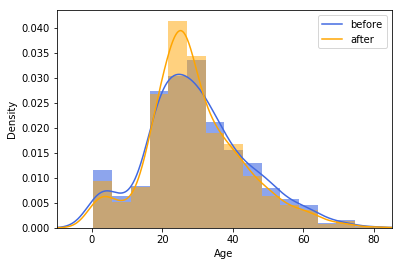

In [27]:
# Plot histogram of ages before nulls were replaced and show this histogram in blue
training_data.Age.hist(bins=15, density = True, stacked = True, alpha = 0.6, color='royalblue')
training_data.Age.plot(kind = 'density', color = 'royalblue', label = 'before')
# Plot histogram of ages after null values were replaced and show the histogram in orange
training_data_2.Age.hist(bins=15, density = True, stacked = True, alpha = 0.5, color='orange')
training_data_2.Age.plot(kind = 'density', color = 'orange', label = 'after')
# Create legend and labels
plt.legend()
plt.xlabel('Age')
plt.xlim(-10,85)
plt.show()

~20% of the age datapoints are missing so it's important to be careful when deciding how to deal with the missing values. 

Since the training data set is not very large so removing 20% of the datapoints would be too substantial and could lead the model to yield less predictive power. Removing the age variable entirely would also not be a good strategy because passengers on board the titanic made efforts to save children first. The best strategy is to figure out a way of replacing missing age values with estimates.

The age variable for is right skewed so median is the best option for replacing missing values. Replacing the missing age variable with the median ages of passengers who have the same passenger class, sex, and port of embarkation ensures that age values are replaced with the median ages of a similar groups of passengers. Graphing the distribution of ages before and after replacements were made shows that the distribution of ages is largely preserved after these replacements are made.

### 2e. Dealing with 'Cabin' missing values

Too many datapoints are missing for this field (~77%). As a result, it is best to exclude this field from the machine learning models.

# 3. Exploring Variables and their Impact on Survival

### 3a. Ticket Class Exploration

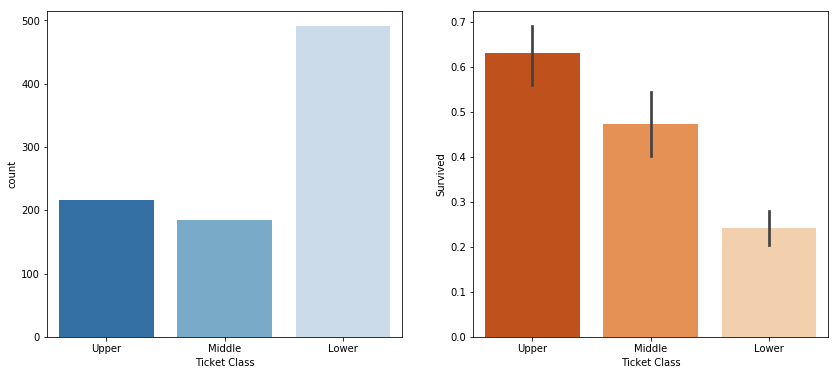

In [28]:
# Set up the figure with two subplots
fig, (axis1,axis2) = plt.subplots(1, 2, figsize=(14,6))
# Create a plot showing the count of observations with upper, middle, and lower classes
sns.countplot(x = 'Pclass', data = training_data_2, palette = 'Blues_r', ax = axis1)
axis1.set_xticklabels(['Upper','Middle','Lower'])
axis1.set_xlabel('Ticket Class')
# Create a plot showing the proportion of people in each class who survived
sns.barplot('Pclass', 'Survived', data = training_data_2, palette = 'Oranges_r', ax = axis2)
axis2.set_xticklabels(['Upper','Middle','Lower'])
axis2.set_xlabel('Ticket Class')
plt.show()

The dataset is composed is significantly more lower class ticket holders than upper or middle class ticket holders. People of higher classes tended to be more likely to survive the shipwreck.

### 3b. Gender Exploration

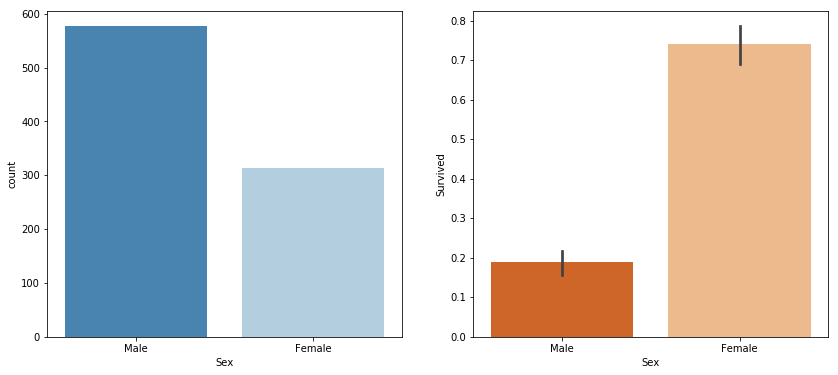

In [29]:
# Set up the figure with two subplots
fig, (axis1,axis2) = plt.subplots(1, 2, figsize=(14,6))
# Create a plot showing the count of observations with upper, middle, and lower classes
sns.countplot(x = 'Sex', data = training_data_2, palette = 'Blues_r', ax = axis1)
axis1.set_xticklabels(['Male','Female'])
axis1.set_xlabel('Sex')
# Create a plot showing the proportion of people in each class who survived
sns.barplot('Sex', 'Survived', data = training_data_2, palette = 'Oranges_r', ax = axis2)
axis2.set_xticklabels(['Male','Female'])
axis2.set_xlabel('Sex')
plt.show()

The dataset is composed is significantly more men than women. Women were much more likely to survive the shipwreck than men.

### 3c. Age Exploration

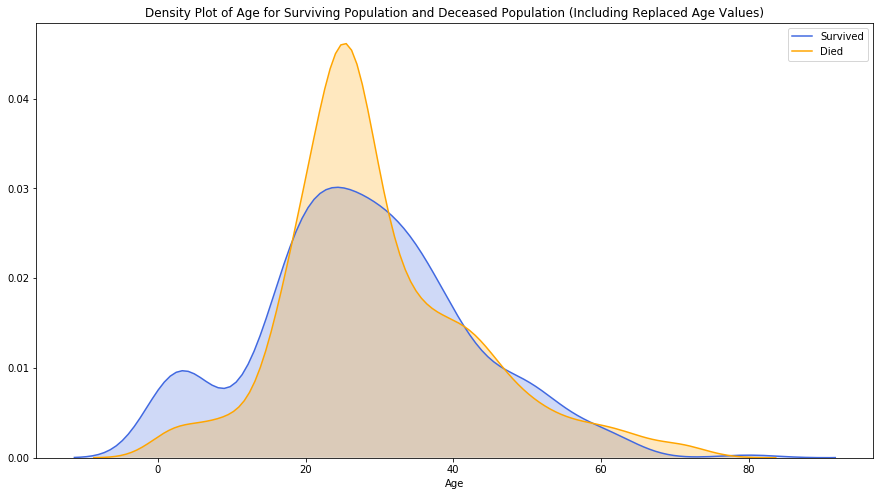

In [30]:
# age distribution for survivers and deceased is relatively similar. However, note that one difference is that of the survivers a larger proportion were children

plt.figure(figsize=(15,8))
ax1 = sns.kdeplot(training_data_2['Age'][training_data_2.Survived == 1], color = 'royalblue', shade=True)
ax2 = sns.kdeplot(training_data_2['Age'][training_data_2.Survived == 0], color = 'orange', shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Age for Surviving Population and Deceased Population (Including Replaced Age Values)')
ax2.set(xlabel = 'Age')
plt.show()

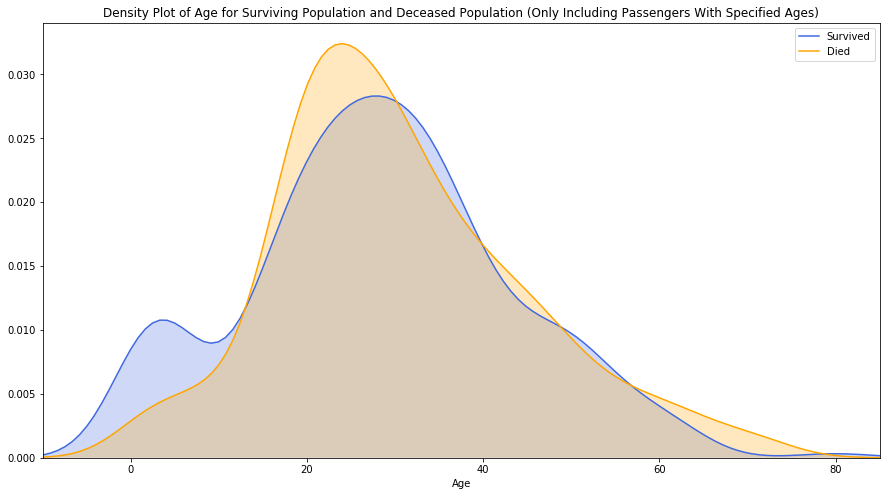

In [31]:
# age distribution for survivers and deceased is relatively similar. However, note that one difference is that of the survivers a larger proportion were children

plt.figure(figsize=(15,8))
ax1 = sns.kdeplot(training_data['Age'][(training_data.Age.notnull()) & (training_data.Survived == 1)], color = 'royalblue', shade=True)
ax2 = sns.kdeplot(training_data['Age'][(training_data.Age.notnull()) & (training_data.Survived == 0)], color = 'orange', shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Age for Surviving Population and Deceased Population (Only Including Passengers With Specified Ages)')
ax2.set(xlabel = 'Age')
plt.xlim(-10,85)
plt.show()

In [32]:
# Look at average survival and count of passengers by age
training_data_2[['Age', 'Survived']].groupby(['Age'], as_index = False).agg(['mean', 'count'])

Survived      
           mean count
Age                  
0.42   1.000000     1
0.67   1.000000     1
0.75   1.000000     2
0.83   1.000000     2
0.92   1.000000     1
1.00   0.714286     7
2.00   0.300000    10
3.00   0.833333     6
4.00   0.700000    10
5.00   1.000000     4
6.00   0.666667     3
7.00   0.333333     3
8.00   0.500000     4
9.00   0.250000     8
10.00  0.000000     2
11.00  0.250000     4
12.00  1.000000     1
13.00  1.000000     2
14.00  0.500000     6
14.25  0.571429     7
14.50  0.000000     1
15.00  0.800000     5
16.00  0.352941    17
17.00  0.461538    13
18.00  0.346154    26
19.00  0.360000    25
20.00  0.578947    38
20.50  0.000000     1
21.00  0.208333    24
22.00  0.407407    27
23.00  0.259259    27
23.50  0.000000     1
24.00  0.500000    30
24.50  0.000000     1
25.00  0.135135    74
26.00  0.250000    36
27.00  0.302326    43
28.00  0.280000    25
28.50  0.000000     2
29.00  0.428571    21
29.50  0.500000     2
30.00  0.363636    33
30.50  0.000000     2
31.00  0.470588    17
32.00  0.500000    18
32.50  0.500000     2
33.00  0.526316    19
34.00  0.400000    15
34.50  0.000000     1
35.00  0.611111    18
36.00  0.500000    22
36.50  0.142857     7
37.00  0.166667     6
38.00  0.625000    16
39.00  0.357143    14
40.00  0.461538    13
40.50  0.000000     2
41.00  0.333333     6
42.00  0.357143    28
43.00  0.200000     5
44.00  0.333333     9
45.00  0.416667    12
45.50  0.000000     2
46.00  0.000000     3
47.00  0.111111     9
48.00  0.666667     9
49.00  0.666667     6
50.00  0.500000    10
51.00  0.285714     7
52.00  0.500000     6
53.00  1.000000     1
54.00  0.375000     8
55.00  0.500000     2
55.50  0.000000     1
56.00  0.500000     4
57.00  0.000000     2
58.00  0.600000     5
59.00  0.000000     2
60.00  0.500000     4
61.00  0.000000     3
62.00  0.500000     4
63.00  1.000000     2
64.00  0.000000     2
65.00  0.000000     3
66.00  0.000000     1
70.00  0.000000     2
70.50  0.000000     1
71.00  0.000000     2
74.00  0.000000     1
80.00  1.000000     1

Above, I use a Kernel Density Plot to show the different distributions of ages for the surviving population and the deceased population. The goal is to see whether or not the distribution of ages for the surviving population is different than that of the deceased population. If the distributions are different, then it's possible that age plays a role in the probability of whether or not someone survived the shipwreck.

The first graph (titled 'Density Plot of Age for Surviving Population and Deceased Population (Including Replaced Age Values)') compares the distribution of ages for people who survived the shipwreck relative to people who did not survive the shipwreck. In the training dataset, ~20% people had null values for age. For the analysis, I replaced null values with the median of individuals grouped by Ticket Class, Sex, and Port of Embarkation. Note that in the first graph, the age distribution for deceased passengers and surviving passengers differs in two ways:

    1. A higher proportion of surviving individuals are between the ages of ~0 and ~18
    2. A higher proportion of deceased passengers are between the ages of ~18 and ~35
    
The second difference is due to replacing null ages with median values. Recall that passengers with missing age values tended to disproportionately exist in the deceased group. 

In the second graph, (titled 'Density Plot of Age for Surviving Population and Deceased Population (Only Including Passengers With Specified Ages)') I plot the same Kernel Density Plot, but with passengers with Age equal to null excluded. This chart shows that The primary difference between the distribution of ages between deceased and surviving passengers is in the younger passenger group.

It looks like the child passengers under the age of 16 are much more likely to survive than passengers in other age groups. Additionally, it looks like passengers in other age groups tend to have similar probabilities of surviving the shipwreck. 

### 3d. Sibling/Spouses On Board the Titanic Variable  Exploration

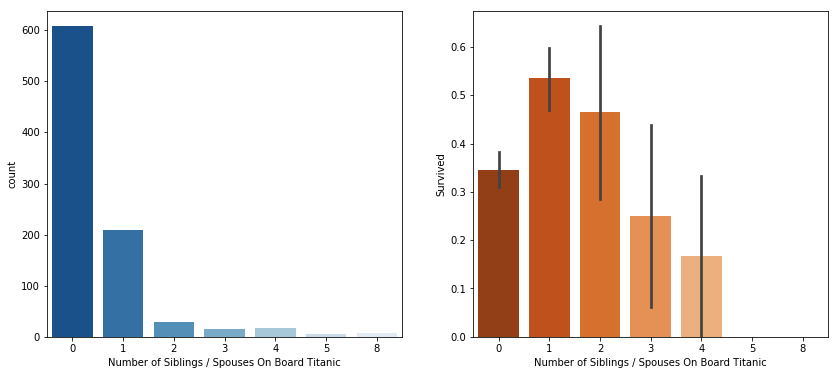

In [33]:
# Set up the figure with two subplots
fig, (axis1,axis2) = plt.subplots(1, 2, figsize=(14,6))
# Create a plot showing the count of observations with different numbers of siblings / spouses on board the titanic
sns.countplot(x = 'SibSp', data = training_data_2, palette = 'Blues_r', ax = axis1)
axis1.set_xlabel('Number of Siblings / Spouses On Board Titanic')
# Create a plot showing the proportion of with different numbers of siblings / spouses onboard the titanic who survived
sns.barplot('SibSp', 'Survived', data = training_data_2, palette = 'Oranges_r', ax = axis2)
axis2.set_xlabel('Number of Siblings / Spouses On Board Titanic')
plt.show()

The vast majority of passengers in the training dataset do not have a sibling or spouse on board the titanic. While the majority of passengers on board the titanic do not have a sibling or spouse on board, there are a large number of passengers with one sibling or spouse on board the titanic. There are very few people with two or more siblings or spouses on board the titanic.

There seems to be higher survivorship for people who have zero siblings/spouses on board the titanic relative to people with one sibling/spouse on board the titanic. Given that there are a low number of people with two or more siblings/spouses on board the titanic, the affect on survivorship is less clear

### 3e. Parents/Children On Board the Titanic Variable Exploration

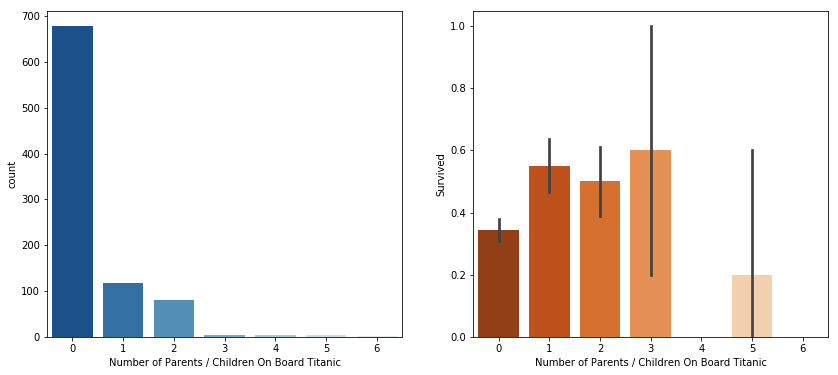

In [34]:
# Set up the figure with two subplots
fig, (axis1,axis2) = plt.subplots(1, 2, figsize=(14,6))
# Create a plot showing the count of observations with different numbers of parents / children on board the titanic
sns.countplot(x = 'Parch', data = training_data_2, palette = 'Blues_r', ax = axis1)
axis1.set_xlabel('Number of Parents / Children On Board Titanic')
# Create a plot showing the proportion of with different numbers of parents / children onboard the titanic who survived
sns.barplot('Parch', 'Survived', data = training_data_2, palette = 'Oranges_r', ax = axis2)
axis2.set_xlabel('Number of Parents / Children On Board Titanic')
plt.show()

The vast majority of passengers in the training dataset do not have a parent / child on board the titanic. While the majority of passengers on board the titanic do not have a parent or child on board, there are a large number of passengers with one or two parents / children on board the titanic. There are very few people with three or more parents or children on board the titanic.

There seems to be higher survivorship for people who have zero parents / children on board the titanic relative to people with one or two parents / children on board the titanic. Given that there are a low number of people with two or more parents/children on board the titanic, the affect on survivorship is less clear

### 3f. Fare Exploration

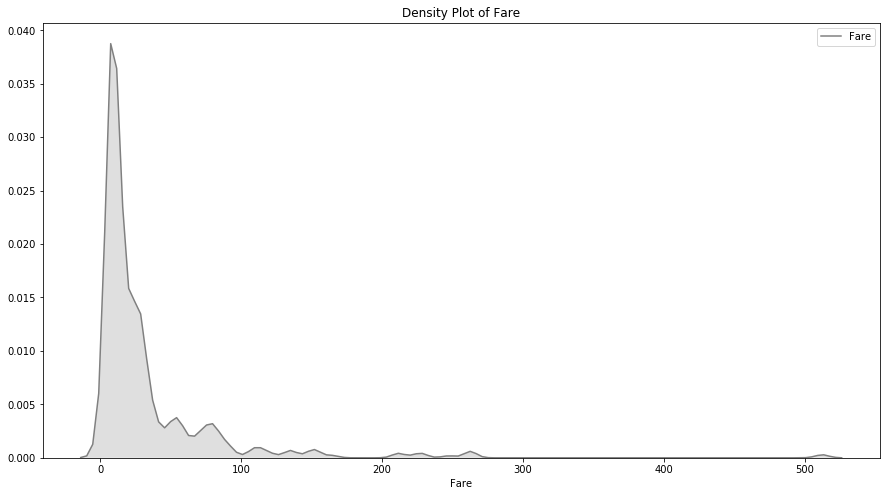

In [35]:
plt.figure(figsize=(15,8))
ax1 = sns.kdeplot(training_data_2['Fare'], color='grey', shade=True)
plt.title('Density Plot of Fare')
ax1.set(xlabel = 'Fare')
plt.show()

In [36]:
training_data_3 = training_data_2.copy()
training_data_3.drop(columns = ['Survived'], inplace = True)
combined_data = training_data_3.append(testing_data_2)
ticket_counts = combined_data.pivot_table(index = 'Ticket', values = ['Name'], aggfunc = {'Name':'count'})
ticket_counts = ticket_counts.rename(columns = {'Name': 'TicketCount'})

In [37]:
training_data_2 = training_data_2.merge(ticket_counts, left_on='Ticket', right_on = 'Ticket')

In [38]:
# training_data_2.merge(ticket_counts, left_on='Ticket', right_on = 'Ticket').sort_values(by=['TicketCount'], ascending = False).head()
training_data_2.sort_values(by=['TicketCount'], ascending = False).head(20)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,TicketCount
245,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,23.0,8,2,CA. 2343,69.5500,NaN,S,11
244,0,3,"Sage, Mr. Douglas Bullen",male,25.0,8,2,CA. 2343,69.5500,NaN,S,11
243,0,3,"Sage, Miss. Stella Anna",female,23.0,8,2,CA. 2343,69.5500,NaN,S,11
242,0,3,"Sage, Mr. George John Jr",male,25.0,8,2,CA. 2343,69.5500,NaN,S,11
241,0,3,"Sage, Mr. Frederick",male,25.0,8,2,CA. 2343,69.5500,NaN,S,11
240,0,3,"Sage, Miss. Constance Gladys",female,23.0,8,2,CA. 2343,69.5500,NaN,S,11
239,0,3,"Sage, Master. Thomas Henry",male,25.0,8,2,CA. 2343,69.5500,NaN,S,11
104,0,3,"Goodwin, Master. Harold Victor",male,9.0,5,2,CA 2144,46.9000,NaN,S,8
134,1,3,"Lang, Mr. Fang",male,26.0,0,0,1601,56.4958,NaN,S,8
132,1,3,"Bing, Mr. Lee",male,32.0,0,0,1601,56.4958,NaN,S,8


In [39]:
training_data_2.drop(columns = ['TicketCount'], inplace = True)

Above are a series of kernel density plots that show the following:
    1. Distribution of the 'Fare' variable as a whole
    2. Distribution of the 'Fare' variable for people who survived the shipwreck relative to people who did not survive the shipwreck
    3. Distribution of the 'Fare' variable for people who are upper class, middle class, and lower class ticket holders
    4. Distribution of the 'Fare' variable for upper class ticket holders who survived the shipwreck relative to upper class ticketholders who did not survive the shipwreck
    5. Distribution of the 'Fare' variable for middle class ticket holders who survived the shipwreck relative to middle class ticketholders who did not survive the shipwreck
    6. Distribution of the 'Fare' variable for lower class ticket holders who survived the shipwreck relative to lower class ticketholders who did not survive the shipwreck

The 'Fare' variable is right skewed with a small proportion of passengers paying very high prices (100 dollars and up) and a large proportion of passengers paying between 0 dollars and 40 dollars. In general, the passengers who survived tended to pay higher prices. Additionally, people of different ticket classes paid substantially different ticket prices (upper class ticket holders tended to pay the highest ticket prices, followed by middle class ticket holders, and lower class ticket holders). The distribution of fare for upper class survivors was similar to the distribution of fare for upper class deceased passengers. The distribution of fare for middle class survivors was similar to the distribution of fare for middle class deceased passengers. The distribution of fare for lower class survivors was similar to the distribution of fare for lower class deceased passengers.

Ultimately, while it does appear that passengers who paid higher prices tended to be more likely to survive, it also appears that fare is very heavily related to ticket class. As a result, ticket class is likely a better predictor of survivorship than ticket fare.

### 3g. Port of Embarkation Exploration

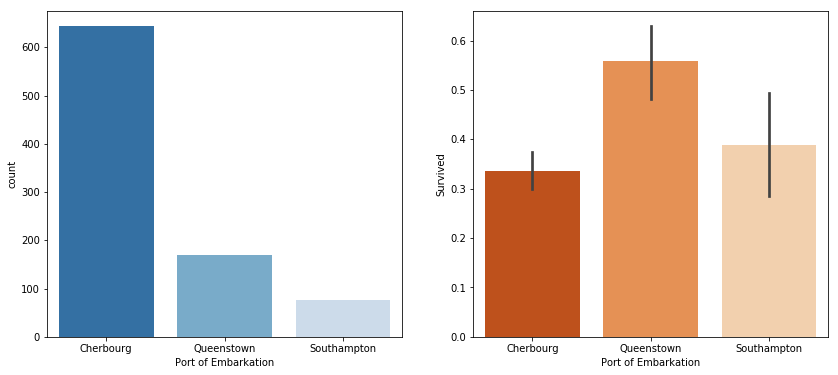

In [40]:
# Set up the figure with two subplots
fig, (axis1,axis2) = plt.subplots(1, 2, figsize=(14,6))
# Create a plot showing the count of observations of passengers leaving from different ports
sns.countplot(x = 'Embarked', data = training_data_2, palette = 'Blues_r', ax = axis1)
axis1.set_xlabel('Port of Embarkation')
axis1.set_xticklabels(['Cherbourg', 'Queenstown', 'Southampton'])
# Create a plot showing the proportion of with different numbers of passengers leaving from different ports
sns.barplot('Embarked', 'Survived', data = training_data_2, palette = 'Oranges_r', ax = axis2)
axis2.set_xlabel('Port of Embarkation')
axis2.set_xticklabels(['Cherbourg','Queenstown', 'Southampton'])
plt.show()

The vast majority of passengers leave from Cherbourg. It appears that passengers from some ports are more likely to survive the shipwreck than others.

# 4. Feature Engineering

### 4a. Isolating the Effect of Age

In [41]:
# Making children be defined as under 16 and adults defined as all other ages
training_data_2['ChildAdult'] = pd.cut(training_data_2['Age'],[0,16,81],  labels = ['child', 'adult'], right = False)
testing_data_2['ChildAdult'] = pd.cut(testing_data_2['Age'],[0,16,81],  labels = ['child', 'adult'], right = False)

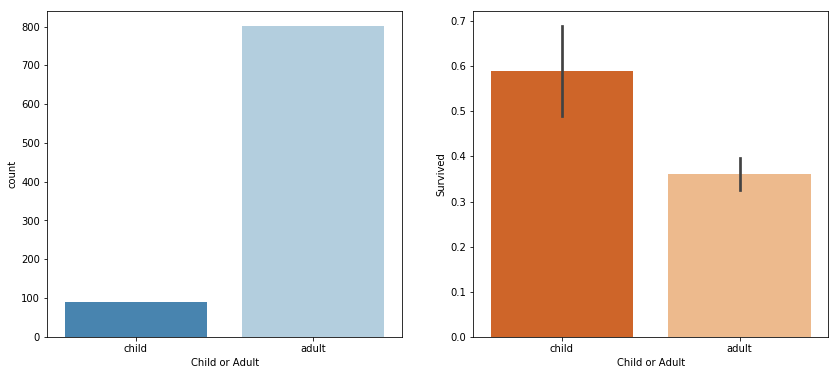

In [42]:
# Set up the figure with two subplots
fig, (axis1,axis2) = plt.subplots(1, 2, figsize=(14,6))
# Create a plot showing the count of observations with different numbers of parents / children on board the titanic
sns.countplot(x = 'ChildAdult', data = training_data_2, palette = 'Blues_r', ax = axis1)
axis1.set_xlabel('Child or Adult')
# Create a plot showing the proportion of with different numbers of family members onboard the titanic who survived
sns.barplot('ChildAdult', 'Survived', data = training_data_2, palette = 'Oranges_r', ax = axis2)
axis2.set_xlabel('Child or Adult')
plt.show()

Children are more likely to survive the shipwreck than adults. I capture children as passengers under the age of 16 and adults as all other passengers.

### 4b. Resolving Parents/Children on Board and Siblings/Spouses on Board Variables

In [43]:
# Create family size variable
training_data_2['FamilySize'] = training_data_2['SibSp'] + training_data_2['Parch']
testing_data_2['FamilySize'] = testing_data_2['SibSp'] + testing_data_2['Parch']

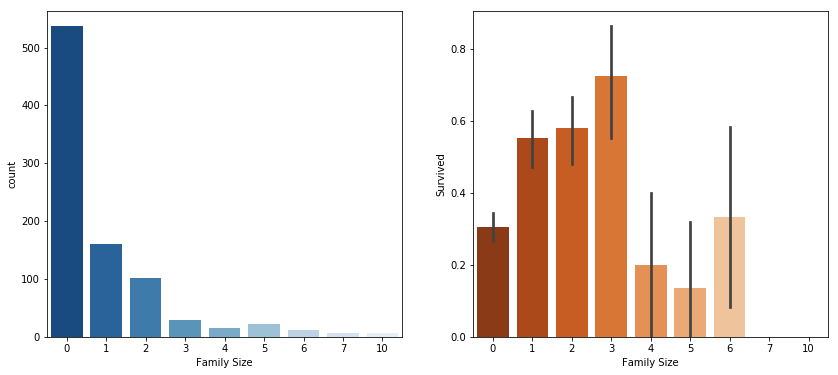

In [44]:
# Set up the figure with two subplots
fig, (axis1,axis2) = plt.subplots(1, 2, figsize=(14,6))
# Create a plot showing the count of observations with different numbers of parents / children on board the titanic
sns.countplot(x = 'FamilySize', data = training_data_2, palette = 'Blues_r', ax = axis1)
axis1.set_xlabel('Family Size')
# Create a plot showing the proportion of with different numbers of family members onboard the titanic who survived
sns.barplot('FamilySize', 'Survived', data = training_data_2, palette = 'Oranges_r', ax = axis2)
axis2.set_xlabel('Family Size')
plt.show()

In [45]:
# Create travel alone variable
training_data_2['WithFamily'] = np.where((training_data_2['FamilySize'] > 0), 1, 0)
testing_data_2['WithFamily'] = np.where((testing_data_2['FamilySize'] > 0), 1, 0)

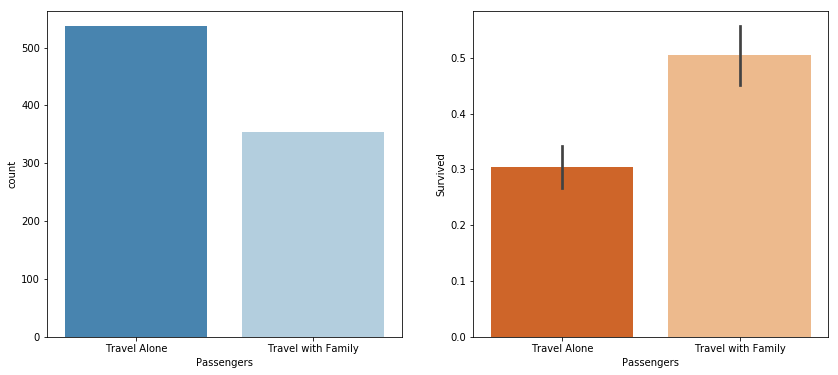

In [46]:
# Set up the figure with two subplots
fig, (axis1,axis2) = plt.subplots(1, 2, figsize=(14,6))
# Create a plot showing the count of observations with different numbers of parents / children on board the titanic
sns.countplot(x = 'WithFamily', data = training_data_2, palette = 'Blues_r', ax = axis1)
axis1.set_xlabel('Passengers')
axis1.set_xticklabels(['Travel Alone','Travel with Family'])
# Create a plot showing the proportion of with different numbers of family members onboard the titanic who survived
sns.barplot('WithFamily', 'Survived', data = training_data_2, palette = 'Oranges_r', ax = axis2)
axis2.set_xlabel('Passengers')
axis2.set_xticklabels(['Travel Alone', 'Travel with Family'])
plt.show()

The variables that capture the number of parents/children she/he is traveling with and the number of siblings/spouses she/he is traveling with are not very readable and I don't have a good reason for keeping them as separate variables. 

I combine the variables into one FamilySize variable that captures the number of family members the passenger is traveling with. 

It appears that passengers traveling alone are significantly less likely to survive the shipwreck than passengers traveling with family. This is possibly due to the fact that passengers traveling alone are disproportionately male. This could also be because traveling with family means that a passenger is more likely to travel with a woman or child -- both of whom are types of passengers that have better odds of surviving the shipwreck.

I isolate the effect by creating a variable that captures whether or not a passenger is traveling with family.  

In [47]:
training_data_2['IsChild'] = np.where(training_data_2['ChildAdult'] == 'child', 1 , 0)
testing_data_2['IsChild'] = np.where(testing_data_2['ChildAdult'] == 'child', 1 , 0)


training_data_2['IsFemale'] = np.where(training_data_2['Sex'] == 'female', 1 , 0)
testing_data_2['IsFemale'] = np.where(testing_data_2['Sex'] == 'female', 1 , 0)

In [48]:
training_data_4 = training_data_2.copy()
training_data_4.drop(columns = ['Survived'], inplace = True)
combined_data_2 = training_data_4.append(testing_data_2)

ticket_counts_2 = combined_data_2.pivot_table(index = 'Ticket', values = ['Name','IsChild', 'IsFemale'], aggfunc = {'Name':'count', 'IsChild':'sum', 'IsFemale':'sum'})
ticket_counts_2 = ticket_counts_2.rename(columns = {'Name': 'TicketCount', 'IsChild':'NumberOfChildren','IsFemale':'NumberOfFemales'})


In [49]:
training_data_2 = training_data_2.merge(ticket_counts_2, left_on='Ticket', right_on = 'Ticket')
testing_data_2 = testing_data_2.merge(ticket_counts_2, left_on='Ticket', right_on = 'Ticket')

In [50]:
training_data_2.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,ChildAdult,FamilySize,WithFamily,IsChild,IsFemale,NumberOfChildren,NumberOfFemales,TicketCount
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,adult,1,1,0,0,0,0,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,adult,1,1,0,1,0,1,2
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,adult,0,0,0,1,0,1,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,adult,1,1,0,1,0,1,2
4,0,1,"Futrelle, Mr. Jacques Heath",male,37.0,1,0,113803,53.1000,C123,S,adult,1,1,0,0,0,1,2


In [51]:
testing_data_2.columns

Index(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked', 'ChildAdult', 'FamilySize', 'WithFamily',
       'IsChild', 'IsFemale', 'NumberOfChildren', 'NumberOfFemales',
       'TicketCount'],
      dtype='object')

In [52]:
training_data_2['TravelWChild'] = np.where((training_data_2['NumberOfChildren']>0) & (training_data_2['ChildAdult'] == 'adult'),1,0)
testing_data_2['TravelWChild'] = np.where((testing_data_2['NumberOfChildren']>0) & (testing_data_2['ChildAdult'] == 'adult'),1,0)

training_data_2['TravelWFemale'] = np.where((training_data_2['NumberOfFemales']>0) & (training_data_2['Sex'] == 'male'),1,0)
testing_data_2['TravelWFemale'] = np.where((testing_data_2['NumberOfFemales']>0) & (testing_data_2['Sex'] == 'male'),1,0)

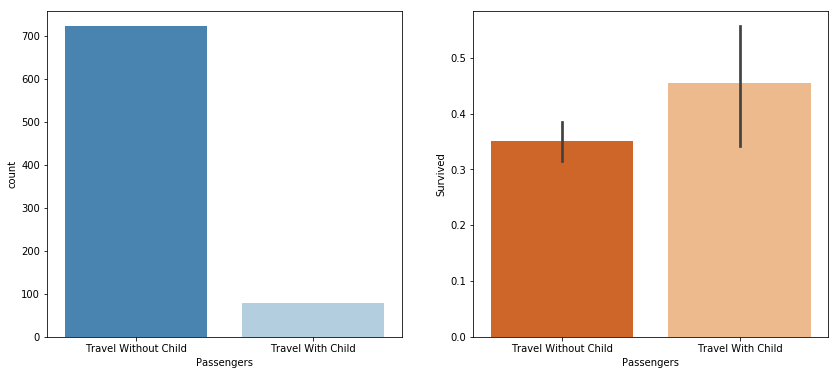

In [53]:
# Set up the figure with two subplots
fig, (axis1,axis2) = plt.subplots(1, 2, figsize=(14,6))
# Create a plot showing the count of observations with different numbers of parents / children on board the titanic
sns.countplot(x = 'TravelWChild', data = training_data_2[training_data_2['ChildAdult']=='adult'], palette = 'Blues_r', ax = axis1)
axis1.set_xlabel('Passengers')
axis1.set_xticklabels(['Travel Without Child', 'Travel With Child'])
# Create a plot showing the proportion of with different numbers of family members onboard the titanic who survived
sns.barplot('TravelWChild', 'Survived', data = training_data_2[training_data_2['ChildAdult']=='adult'] , palette = 'Oranges_r', ax = axis2)
axis2.set_xlabel('Passengers')
axis2.set_xticklabels(['Travel Without Child', 'Travel With Child'])
plt.show()

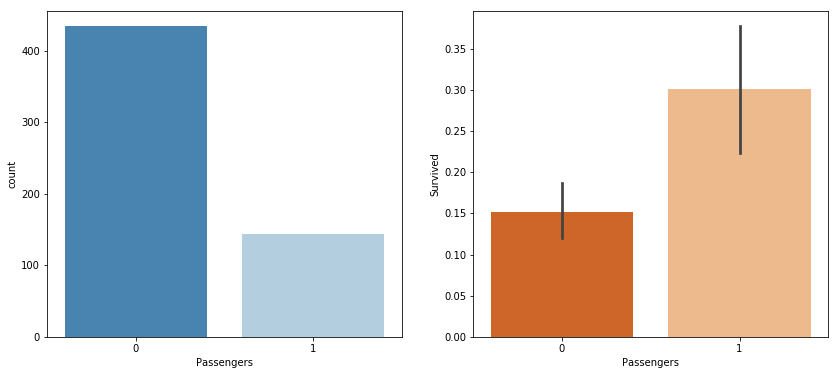

In [54]:
# Set up the figure with two subplots
fig, (axis1,axis2) = plt.subplots(1, 2, figsize=(14,6))
# Create a plot showing the count of observations with different numbers of parents / children on board the titanic
sns.countplot(x = 'TravelWFemale', data = training_data_2[training_data_2['Sex']=='male'], palette = 'Blues_r', ax = axis1)
axis1.set_xlabel('Passengers')
# Create a plot showing the proportion of with different numbers of family members onboard the titanic who survived
sns.barplot('TravelWFemale', 'Survived', data = training_data_2[training_data_2['Sex']=='male'], palette = 'Oranges_r', ax = axis2)
axis2.set_xlabel('Passengers')
plt.show()

### 4c. Turning 'Fare' feature into 'FarePerPassenger'

In [55]:
training_data_2['FarePerPassenger'] = training_data_2['Fare'] / training_data_2['TicketCount']
testing_data_2['FarePerPassenger'] = testing_data_2['Fare'] / testing_data_2['TicketCount']

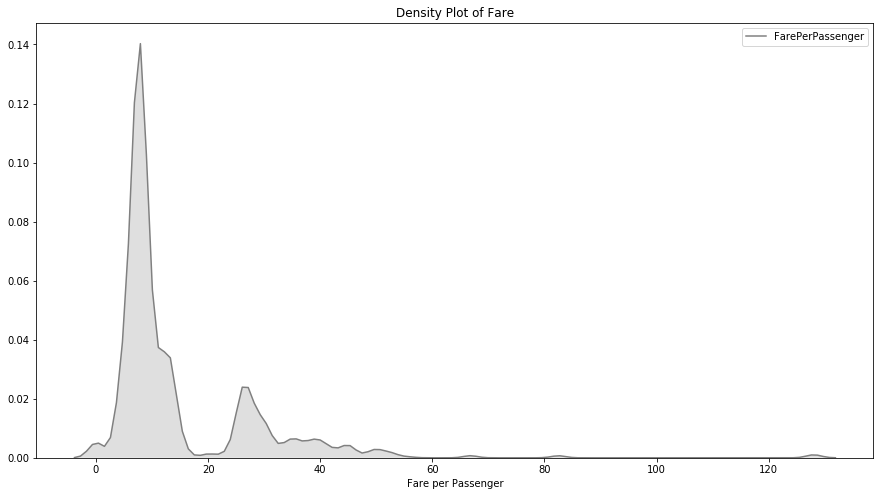

In [56]:
plt.figure(figsize=(15,8))
ax1 = sns.kdeplot(training_data_2['FarePerPassenger'], color='grey', shade=True)
plt.title('Density Plot of Fare')
ax1.set(xlabel = 'Fare per Passenger')
plt.show()

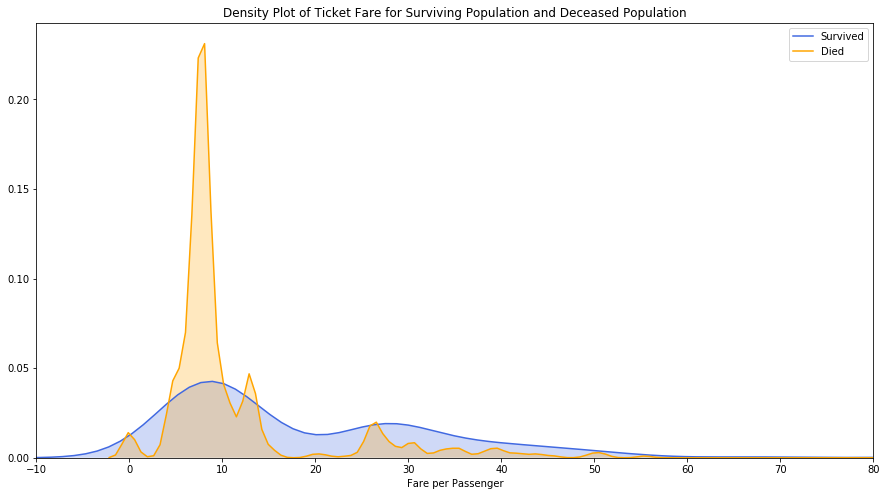

In [57]:
plt.figure(figsize=(15,8))
ax1 = sns.kdeplot(training_data_2['FarePerPassenger'][(training_data_2.Survived == 1)], color='royalblue', shade=True)
ax2 = sns.kdeplot(training_data_2['FarePerPassenger'][(training_data_2.Survived == 0)], color='orange', shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Ticket Fare for Surviving Population and Deceased Population')
ax2.set(xlabel = 'Fare per Passenger')
plt.xlim(-10,80)
plt.show()

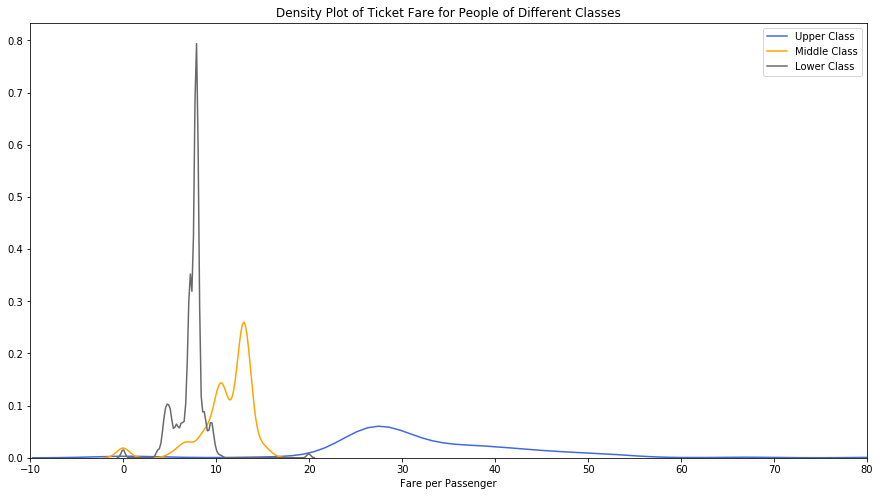

In [58]:
plt.figure(figsize=(15,8))
ax1 = sns.kdeplot(training_data_2['FarePerPassenger'][(training_data_2.Pclass == 1)], color = 'royalblue')
ax2 = sns.kdeplot(training_data_2['FarePerPassenger'][(training_data_2.Pclass == 2)], color = 'orange')
ax3 = sns.kdeplot(training_data_2['FarePerPassenger'][(training_data_2.Pclass == 3)], color = 'dimgray')
plt.legend(['Upper Class', 'Middle Class', 'Lower Class'])
plt.title('Density Plot of Ticket Fare for People of Different Classes')
ax2.set(xlabel = 'Fare per Passenger')
plt.xlim(-10,80)
plt.show()

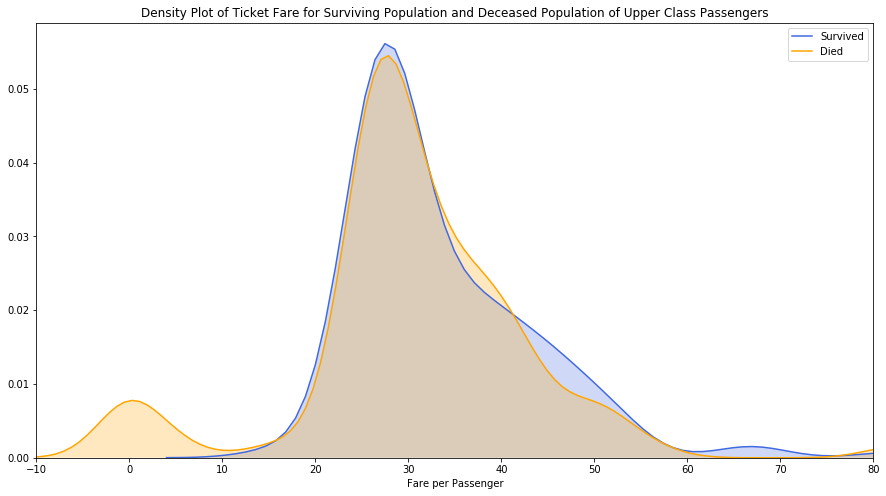

In [59]:
plt.figure(figsize=(15,8))
ax1 = sns.kdeplot(training_data_2['FarePerPassenger'][(training_data_2.Survived == 1) & (training_data_2.Pclass == 1)], color='royalblue', shade=True)
ax2 = sns.kdeplot(training_data_2['FarePerPassenger'][(training_data_2.Survived == 0) & (training_data_2.Pclass == 1)], color='orange', shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Ticket Fare for Surviving Population and Deceased Population of Upper Class Passengers')
ax2.set(xlabel = 'Fare per Passenger')
plt.xlim(-10,80)
plt.show()

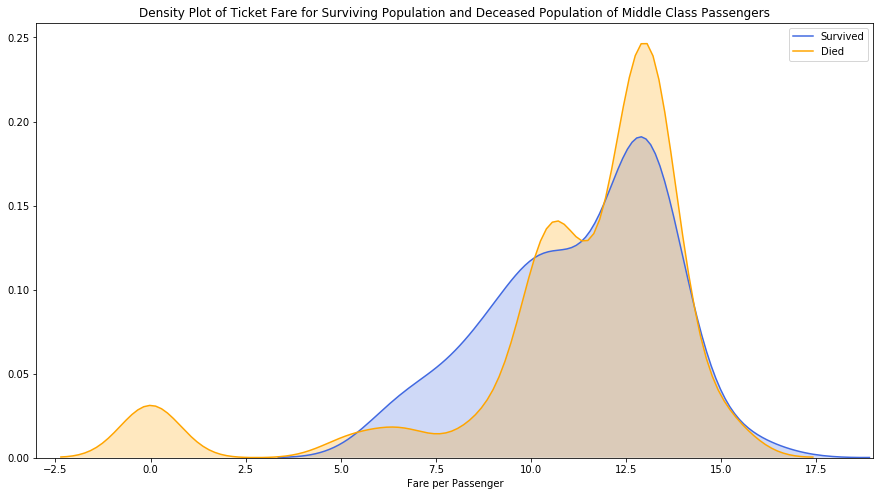

In [60]:
plt.figure(figsize=(15,8))
ax1 = sns.kdeplot(training_data_2['FarePerPassenger'][(training_data_2.Survived == 1) & (training_data_2.Pclass == 2)], color='royalblue', shade=True)
ax2 = sns.kdeplot(training_data_2['FarePerPassenger'][(training_data_2.Survived == 0) & (training_data_2.Pclass == 2)], color='orange', shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Ticket Fare for Surviving Population and Deceased Population of Middle Class Passengers')
ax2.set(xlabel = 'Fare per Passenger')
plt.xlim(-3,19)
plt.show()

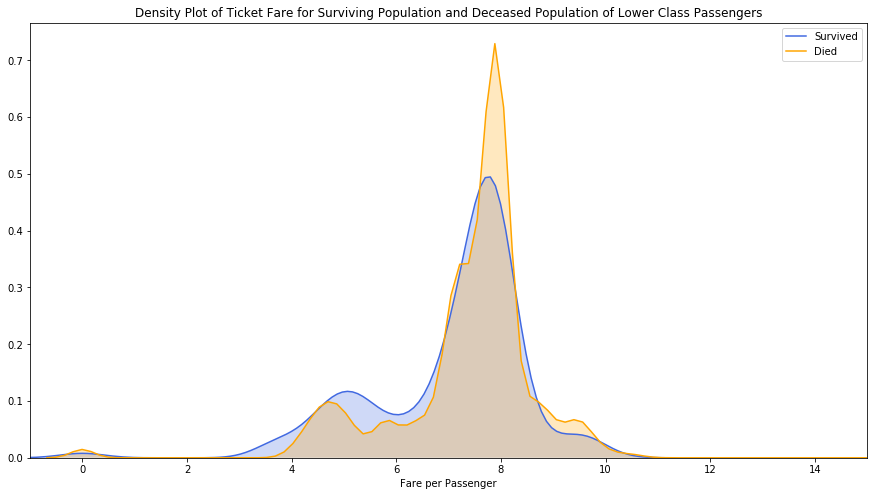

In [61]:
plt.figure(figsize=(15,8))
ax1 = sns.kdeplot(training_data_2['FarePerPassenger'][(training_data_2.Survived == 1) & (training_data_2.Pclass == 3)], color='royalblue', shade=True)
ax2 = sns.kdeplot(training_data_2['FarePerPassenger'][(training_data_2.Survived == 0) & (training_data_2.Pclass == 3)], color='orange', shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Ticket Fare for Surviving Population and Deceased Population of Lower Class Passengers')
ax2.set(xlabel = 'Fare per Passenger')
plt.xlim(-1,15)
plt.show()

# 5. Logistic Regression

### 5a. Background

Logistic regression models the natural log of the odds ratio (logit) of a binary variable of a binar binary variable as its dependent variable. It is used to model the probability of an event occuring. Coefficients for the independent variables in a logistic regression are calculated using the maximum likelihood estimation.

### 5b. Preparation of variables

In [62]:
training_data_cleaned = training_data_2.copy()
testing_data_cleaned = testing_data_2.copy()

log_res_training = training_data_cleaned.copy()

In [63]:
log_res_training.drop(columns = ['Cabin','Age','SibSp', 'Parch', 'WithFamily','Name', 'Ticket','Sex', 'ChildAdult','TicketCount','NumberOfChildren', 'NumberOfFemales', 'Fare'], inplace = True)

In [64]:
log_res_training.columns

Index(['Survived', 'Pclass', 'Embarked', 'FamilySize', 'IsChild', 'IsFemale',
       'TravelWChild', 'TravelWFemale', 'FarePerPassenger'],
      dtype='object')

In [65]:
# Create binary variables for all categorical variables
log_res_training = pd.get_dummies(log_res_training, columns = ['Embarked'], drop_first = True)

In [66]:
# Apply standard scaler to 'Fare' column
fare_per_passenger = log_res_training[['FarePerPassenger']].values
fare_per_passenger = StandardScaler().fit_transform(fare_per_passenger)
log_res_training['FarePerPassenger'] = fare_per_passenger

In [67]:
# Take a look at the final dataset
log_res_training.head()

,Survived,Pclass,FamilySize,IsChild,IsFemale,TravelWChild,TravelWFemale,FarePerPassenger,Embarked_Q,Embarked_S
0,0,3,1,0,0,0,0,-0.538133,0,1
1,1,1,1,0,1,0,0,1.554499,0,0
2,1,3,0,0,1,0,0,-0.488382,0,1
3,1,1,1,0,1,0,0,0.884390,0,1
4,0,1,1,0,0,0,1,0.884390,0,1


In [68]:
# Define the dependent and independent variables
y_logistic = log_res_training.iloc[:,0].values
X_logistic = log_res_training.iloc[:,1:].values

In order to prepare the dataset for logistic regression, I change change the nominal variables (Sex, Embarked, and ChildAdult) into separate binary variables for each of the classifications. For example, 'Embarked' has a separate binary variable for whether or not the passenger embarked from Cherbourg, Queenstown, or Southhampton. Then, I remove one of the binary variables from each in order to avoid perfect multicollinearity in between the independent variables. For example, If I just include the binary variables indicating if the passenger embarked from 'Queenstown' or 'Southhampton', I don't include the binary variable indicating whether or not the passenger embarked from 'Cherbourg' because the effect of a passenger embarking from 'Cherbourg' is already captured in the intercept term. 

Coefficients in the logistic regression are created using gradient descent. As a result, it's important to apply feature scaling to variables with wide ranges to ensure that the conversion to the global minimum (the gradient descent process that happens to create the coefficients) happens more quickly. It's also important weigh the pros of improvements to model efficiency that feature scaling provides with the cons of the loss of meaning to coefficients that happens after feature scaling is applied. 

Pclass is a variable that indicates whether a passenger is upper class, middle class, or lower class on the ship. The variable is originally indicated as 1 (upper), 2 (middle), or 3 (lower). I kept this variable indicated as 1, 2, or 3 in order to preserve the ordinal quality ofthe data. Additionally, I opted not to normalize this variable or scale it down. This is because the variable doesn't get very large (only goes up to three) so I determined that maintaining the interpretability of this variable was more important than any marginal efficiency gains the model would benefit from after scaling this variable down.

Fare is a variable that indicates the price the passenger paid for her/his ticket. This variable ranges from $0 to over $500. As a result of this wide range, I opted to standardize the variable. This means, I scaled down the feature based on the normal distrbution so that the mean of the variable is ~0 and the standard deviation of the variable is ~1.

### 5c. Finalizing the variables to go into Logistic Regression

In [69]:
# Fit a logistic model to the data
classifier_2 = sm.Logit(endog = y_logistic, exog = X_logistic).fit()

Optimization terminated successfully.
         Current function value: 0.436265
         Iterations 6


In [70]:
# Show coefficients of the logistic regression
classifier_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  891
Model:                          Logit   Df Residuals:                      882
Method:                           MLE   Df Model:                            8
Date:                Fri, 03 Jul 2020   Pseudo R-squ.:                  0.3449
Time:                        23:39:39   Log-Likelihood:                -388.71
converged:                       True   LL-Null:                       -593.33
                                        LLR p-value:                 1.985e-83
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.7312      0.096     -7.595      0.000      -0.920      -0.543
x2            -0.4309      0.089     -4.866      0.000      -0.604      -0.257
x3             1.8695      0.383      4.881      0.000       1.119       2.620
x4             2.9995      0.227     13.230      0.000       2.555       3.444
x5             0.7736      0.372      2.079      0.038       0.044       1.503
x6             0.7913      0.280      2.829      0.005       0.243       1.339
x7             0.2504      0.110      2.277      0.023       0.035       0.466
x8             0.1893      0.389      0.486      0.627      -0.574       0.952
x9            -0.0826      0.217     -0.381      0.703      -0.508       0.342
==============================================================================
"""

In [71]:
# The 'TravelWChild' variable (Binary variable indicating whether or not the individual traveled with a child) has a high p-value revealing that the variable is not statistically significant in this model. Removing the TravelWChild variable
X_logistic = np.delete(X_logistic,4, axis = 1)

In [72]:
# Fit a logistic model to the data (with the 'Embarked_Q' variable removed) 
classifier_2 = sm.Logit(endog = y_logistic, exog = X_logistic).fit()

Optimization terminated successfully.
         Current function value: 0.438736
         Iterations 6


In [73]:
# Show coefficients of the logistic regression
classifier_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  891
Model:                          Logit   Df Residuals:                      883
Method:                           MLE   Df Model:                            7
Date:                Fri, 03 Jul 2020   Pseudo R-squ.:                  0.3411
Time:                        23:39:39   Log-Likelihood:                -390.91
converged:                       True   LL-Null:                       -593.33
                                        LLR p-value:                 2.199e-83
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.7158      0.095     -7.523      0.000      -0.902      -0.529
x2            -0.3508      0.078     -4.503      0.000      -0.504      -0.198
x3             1.5422      0.343      4.495      0.000       0.870       2.215
x4             3.0657      0.224     13.657      0.000       2.626       3.506
x5             0.8492      0.279      3.045      0.002       0.303       1.396
x6             0.2083      0.106      1.961      0.050       0.000       0.417
x7             0.0547      0.384      0.142      0.887      -0.699       0.808
x8            -0.1163      0.216     -0.539      0.590      -0.539       0.306
==============================================================================
"""

In [74]:
# The 'Embarked_Q' variable (Binary variable indicating whether or not the individual embarked the Titanic from the Queenstown port) has a high p-value revealing that the variable is not statistically significant in this model. Removing the Embarked_Q variable
X_logistic = np.delete(X_logistic,6, axis = 1)

In [75]:
# Fit a logistic model to the data (with the 'TravelWChild' and 'Embarked_Q' variables removed)
classifier_2 = sm.Logit(endog = y_logistic, exog = X_logistic).fit()

Optimization terminated successfully.
         Current function value: 0.438748
         Iterations 6


In [76]:
# Show coefficients of the logistic regression
classifier_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  891
Model:                          Logit   Df Residuals:                      884
Method:                           MLE   Df Model:                            6
Date:                Fri, 03 Jul 2020   Pseudo R-squ.:                  0.3411
Time:                        23:39:39   Log-Likelihood:                -390.92
converged:                       True   LL-Null:                       -593.33
                                        LLR p-value:                 2.588e-84
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.7088      0.081     -8.729      0.000      -0.868      -0.550
x2            -0.3515      0.078     -4.518      0.000      -0.504      -0.199
x3             1.5354      0.340      4.517      0.000       0.869       2.202
x4             3.0702      0.222     13.808      0.000       2.634       3.506
x5             0.8535      0.277      3.079      0.002       0.310       1.397
x6             0.2085      0.106      1.960      0.050   -1.76e-05       0.417
x7            -0.1329      0.182     -0.731      0.465      -0.489       0.223
==============================================================================
"""

In [77]:
# The 'Embarked_S' variable (Binary variable indicating whether or not the individual embarked the Titanic from the Southhampton port) has a high p-value revealing that the variable is not statistically significant in this model. Removing the Embarked_S variable
X_logistic = np.delete(X_logistic,6, axis = 1)

In [78]:
# Fit a logistic model to the data (with the 'Embarked_Q', 'Embarked_Q', and 'TravelWChild' variables removed)
classifier_2 = sm.Logit(endog = y_logistic, exog = X_logistic).fit()

Optimization terminated successfully.
         Current function value: 0.439047
         Iterations 6


In [79]:
# Show coefficients of the logistic regression
classifier_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  891
Model:                          Logit   Df Residuals:                      885
Method:                           MLE   Df Model:                            5
Date:                Fri, 03 Jul 2020   Pseudo R-squ.:                  0.3407
Time:                        23:39:39   Log-Likelihood:                -391.19
converged:                       True   LL-Null:                       -593.33
                                        LLR p-value:                 3.559e-85
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.7482      0.061    -12.224      0.000      -0.868      -0.628
x2            -0.3601      0.077     -4.664      0.000      -0.511      -0.209
x3             1.5578      0.339      4.602      0.000       0.894       2.221
x4             3.0814      0.223     13.849      0.000       2.645       3.517
x5             0.8576      0.277      3.093      0.002       0.314       1.401
x6             0.1930      0.103      1.877      0.060      -0.008       0.394
==============================================================================
"""

In [80]:
# The 'Pclass' variable (variable indicating whether a passenger is 1st, 2nd, or 3rd class) has a high p-value revealing that the variable is not statistically significant in this model. Removing the Pclass variable
X_logistic = np.delete(X_logistic,1, axis = 1)

In [81]:
# Fit a logistic model to the data (with the 'Embarked_Q', 'Embarked_Q', and 'Pclass' variables removed)
classifier_2 = sm.Logit(endog = y_logistic, exog = X_logistic).fit()

Optimization terminated successfully.
         Current function value: 0.453943
         Iterations 6


In [82]:
# Show coefficients of the logistic regression
classifier_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  891
Model:                          Logit   Df Residuals:                      886
Method:                           MLE   Df Model:                            4
Date:                Fri, 03 Jul 2020   Pseudo R-squ.:                  0.3183
Time:                        23:39:39   Log-Likelihood:                -404.46
converged:                       True   LL-Null:                       -593.33
                                        LLR p-value:                 1.801e-80
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.7658      0.062    -12.441      0.000      -0.886      -0.645
x2             1.0061      0.295      3.408      0.001       0.427       1.585
x3             2.6836      0.201     13.352      0.000       2.290       3.077
x4             0.3199      0.256      1.250      0.211      -0.182       0.821
x5             0.2273      0.102      2.238      0.025       0.028       0.426
==============================================================================
"""

In [83]:
# The 'Ischild' variable (variable indicating whether a passenger is under the age of 16 or not) has a high p-value revealing that the variable is not statistically significant in this model. Removing the IsChild variable
X_logistic = np.delete(X_logistic,3, axis = 1)

In [84]:
# Fit a logistic model to the data (with the 'Embarked_Q', 'Embarked_S', 'Pclass', and 'IsChild' variables removed)
classifier_2 = sm.Logit(endog = y_logistic, exog = X_logistic).fit()

Optimization terminated successfully.
         Current function value: 0.454805
         Iterations 6


In [85]:
# Show coefficients of the logistic regression
classifier_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  891
Model:                          Logit   Df Residuals:                      887
Method:                           MLE   Df Model:                            3
Date:                Fri, 03 Jul 2020   Pseudo R-squ.:                  0.3170
Time:                        23:39:39   Log-Likelihood:                -405.23
converged:                       True   LL-Null:                       -593.33
                                        LLR p-value:                 3.174e-81
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.7298      0.053    -13.731      0.000      -0.834      -0.626
x2             1.1313      0.284      3.990      0.000       0.576       1.687
x3             2.5879      0.184     14.075      0.000       2.227       2.948
x4             0.2806      0.094      3.000      0.003       0.097       0.464
==============================================================================
"""

I ran the logistic regression model the first time using the following independent variables:
* 'Pclass': An ordinal variable indicating someone's passenger class using a rating of 1 (upper class), 2 (middle class), or 3 (lower class)
* 'Fare': The price that the passenger paid to board the ship (note that this variable was standardized to have a mean of 0 and a standard deviation of ~1
* 'WithFamily': A binary variable indicating whether or not the passenger was traveling with family. 1 means that she/he is traveling with at least one other family member and 0 means that she/he is traveling alone
* 'Sex_male': A binary variable indicating whether or not the passenger is male. 1 indicates that she/he is male. 0 indicates that she/he is female
* 'Embarked_Q': A binary variable indicating whether or not the passenger embarked from the Queenstown port. 1 indicates that she/he embarked the titanic from Queenstown. 0 indicates that she/he embarked from another port.
* 'Embarked_S': A binary variable indicating whether or not the passenger embarked from the Southampton port. 1 indicates that she/he embarked the titanic from Southampton. 0 indicates that she/he embarked from another port.
* 'ChildAdult_adult': A binary variable indicating whether or not the passenger is an adult (defined as 16 or over in this model). 1 indicates that the passenger is an adult. 0 indicates that the passenger is a child.

The p-value for regression coefficients quantifies how confident we are that the independent variable impacts the depdendent variable. The smaller the p value, the stronger the evidence tha there is a relationship between the independent and dependent variables. I use a p-value threshold of 0.05 in this regression. 

In this regression, there isn't a good reason to keep insignificant variables in the model. So I drop the independent variable with the highest p-value of all the independent variables with p-values > 0.05 and rerun the model with the variable excluded. I repeat this process until only independent variables with p-values < 0.05 are included in the model. 

I am left with the following variables in the model:
* 'Fare': The price that the passenger paid to board the ship (note that this variable was standardized to have a mean of 0 and a standard deviation of ~1
* 'WithFamily': A binary variable indicating whether or not the passenger was traveling with family. 1 means that she/he is traveling with at least one other family member and 0 means that she/he is traveling alone
* 'Sex_male': A binary variable indicating whether or not the passenger is male. 1 indicates that she/he is male. 0 indicates that she/he is female
* 'ChildAdult_adult': A binary variable indicating whether or not the passenger is an adult (defined as 16 or over in this model). 1 indicates that the passenger is an adult. 0 indicates that the passenger is a child.

In [86]:
X_train, X_test, y_train, y_test = train_test_split (X_logistic, y_logistic, test_size = 0.2, random_state = 0, stratify = y_logistic)

In [87]:
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [88]:
y_pred = classifier.predict(X_test)

In [89]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.82      0.83       110
           1       0.72      0.74      0.73        69

    accuracy                           0.79       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



In [90]:
cm = confusion_matrix(y_test, y_pred)

In [91]:
print(cm)
print('---------------------------------------')
print('Precision: ' + str(precision_score(y_test, y_pred)))
print('Recall: ' + str(recall_score(y_test, y_pred)))
print('F1 Score: ' + str(f1_score(y_test, y_pred)))

[[90 20]
 [18 51]]
---------------------------------------
Precision: 0.7183098591549296
Recall: 0.7391304347826086
F1 Score: 0.7285714285714284


In [92]:
dec_tree_training = training_data_cleaned.copy()

In [93]:
dec_tree_training.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,FamilySize,WithFamily,IsChild,IsFemale,NumberOfChildren,NumberOfFemales,TicketCount,TravelWChild,TravelWFemale,FarePerPassenger
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,...,1,1,0,0,0,0,1,0,0,7.25000
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,...,1,1,0,1,0,1,2,0,0,35.64165
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,...,0,0,0,1,0,1,1,0,0,7.92500
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,...,1,1,0,1,0,1,2,0,0,26.55000
4,0,1,"Futrelle, Mr. Jacques Heath",male,37.0,1,0,113803,53.1000,C123,...,1,1,0,0,0,1,2,0,1,26.55000


In [94]:
dec_tree_training.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'ChildAdult', 'FamilySize', 'WithFamily',
       'IsChild', 'IsFemale', 'NumberOfChildren', 'NumberOfFemales',
       'TicketCount', 'TravelWChild', 'TravelWFemale', 'FarePerPassenger'],
      dtype='object')

In [95]:
dec_tree_training.drop(columns = ['Cabin','SibSp', 'Parch','Name', 'Ticket','Sex', 'ChildAdult','IsChild','WithFamily','TicketCount','NumberOfChildren', 'NumberOfFemales', 'Fare'], inplace = True)

In [96]:
dec_tree_training.columns

Index(['Survived', 'Pclass', 'Age', 'Embarked', 'FamilySize', 'IsFemale',
       'TravelWChild', 'TravelWFemale', 'FarePerPassenger'],
      dtype='object')

In [97]:
dec_tree_training = pd.get_dummies(dec_tree_training, columns = ['Embarked'], drop_first = True)

In [98]:
y = dec_tree_training.iloc[:,0].values
X = dec_tree_training.iloc[:,1:].values

In [99]:
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.2, random_state = 0, stratify = y)

In [100]:
tree_1 = DecisionTreeClassifier()
tree_1 = tree_1.fit(X_train, y_train)
y_pred = tree_1.predict(X_test)

In [101]:
cm = confusion_matrix(y_test, y_pred)

In [102]:
print(cm)
print('---------------------------------------')
print('Precision: ' + str(precision_score(y_test, y_pred)))
print('Recall: ' + str(recall_score(y_test, y_pred)))
print('F1 Score: ' + str(f1_score(y_test, y_pred)))

[[87 23]
 [18 51]]
---------------------------------------
Precision: 0.6891891891891891
Recall: 0.7391304347826086
F1 Score: 0.7132867132867132


In [103]:
dec_tree_training.iloc[:,1:].columns

Index(['Pclass', 'Age', 'FamilySize', 'IsFemale', 'TravelWChild',
       'TravelWFemale', 'FarePerPassenger', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [104]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)

roc_auc = auc(false_positive_rate, true_positive_rate)

roc_auc

0.7650197628458497

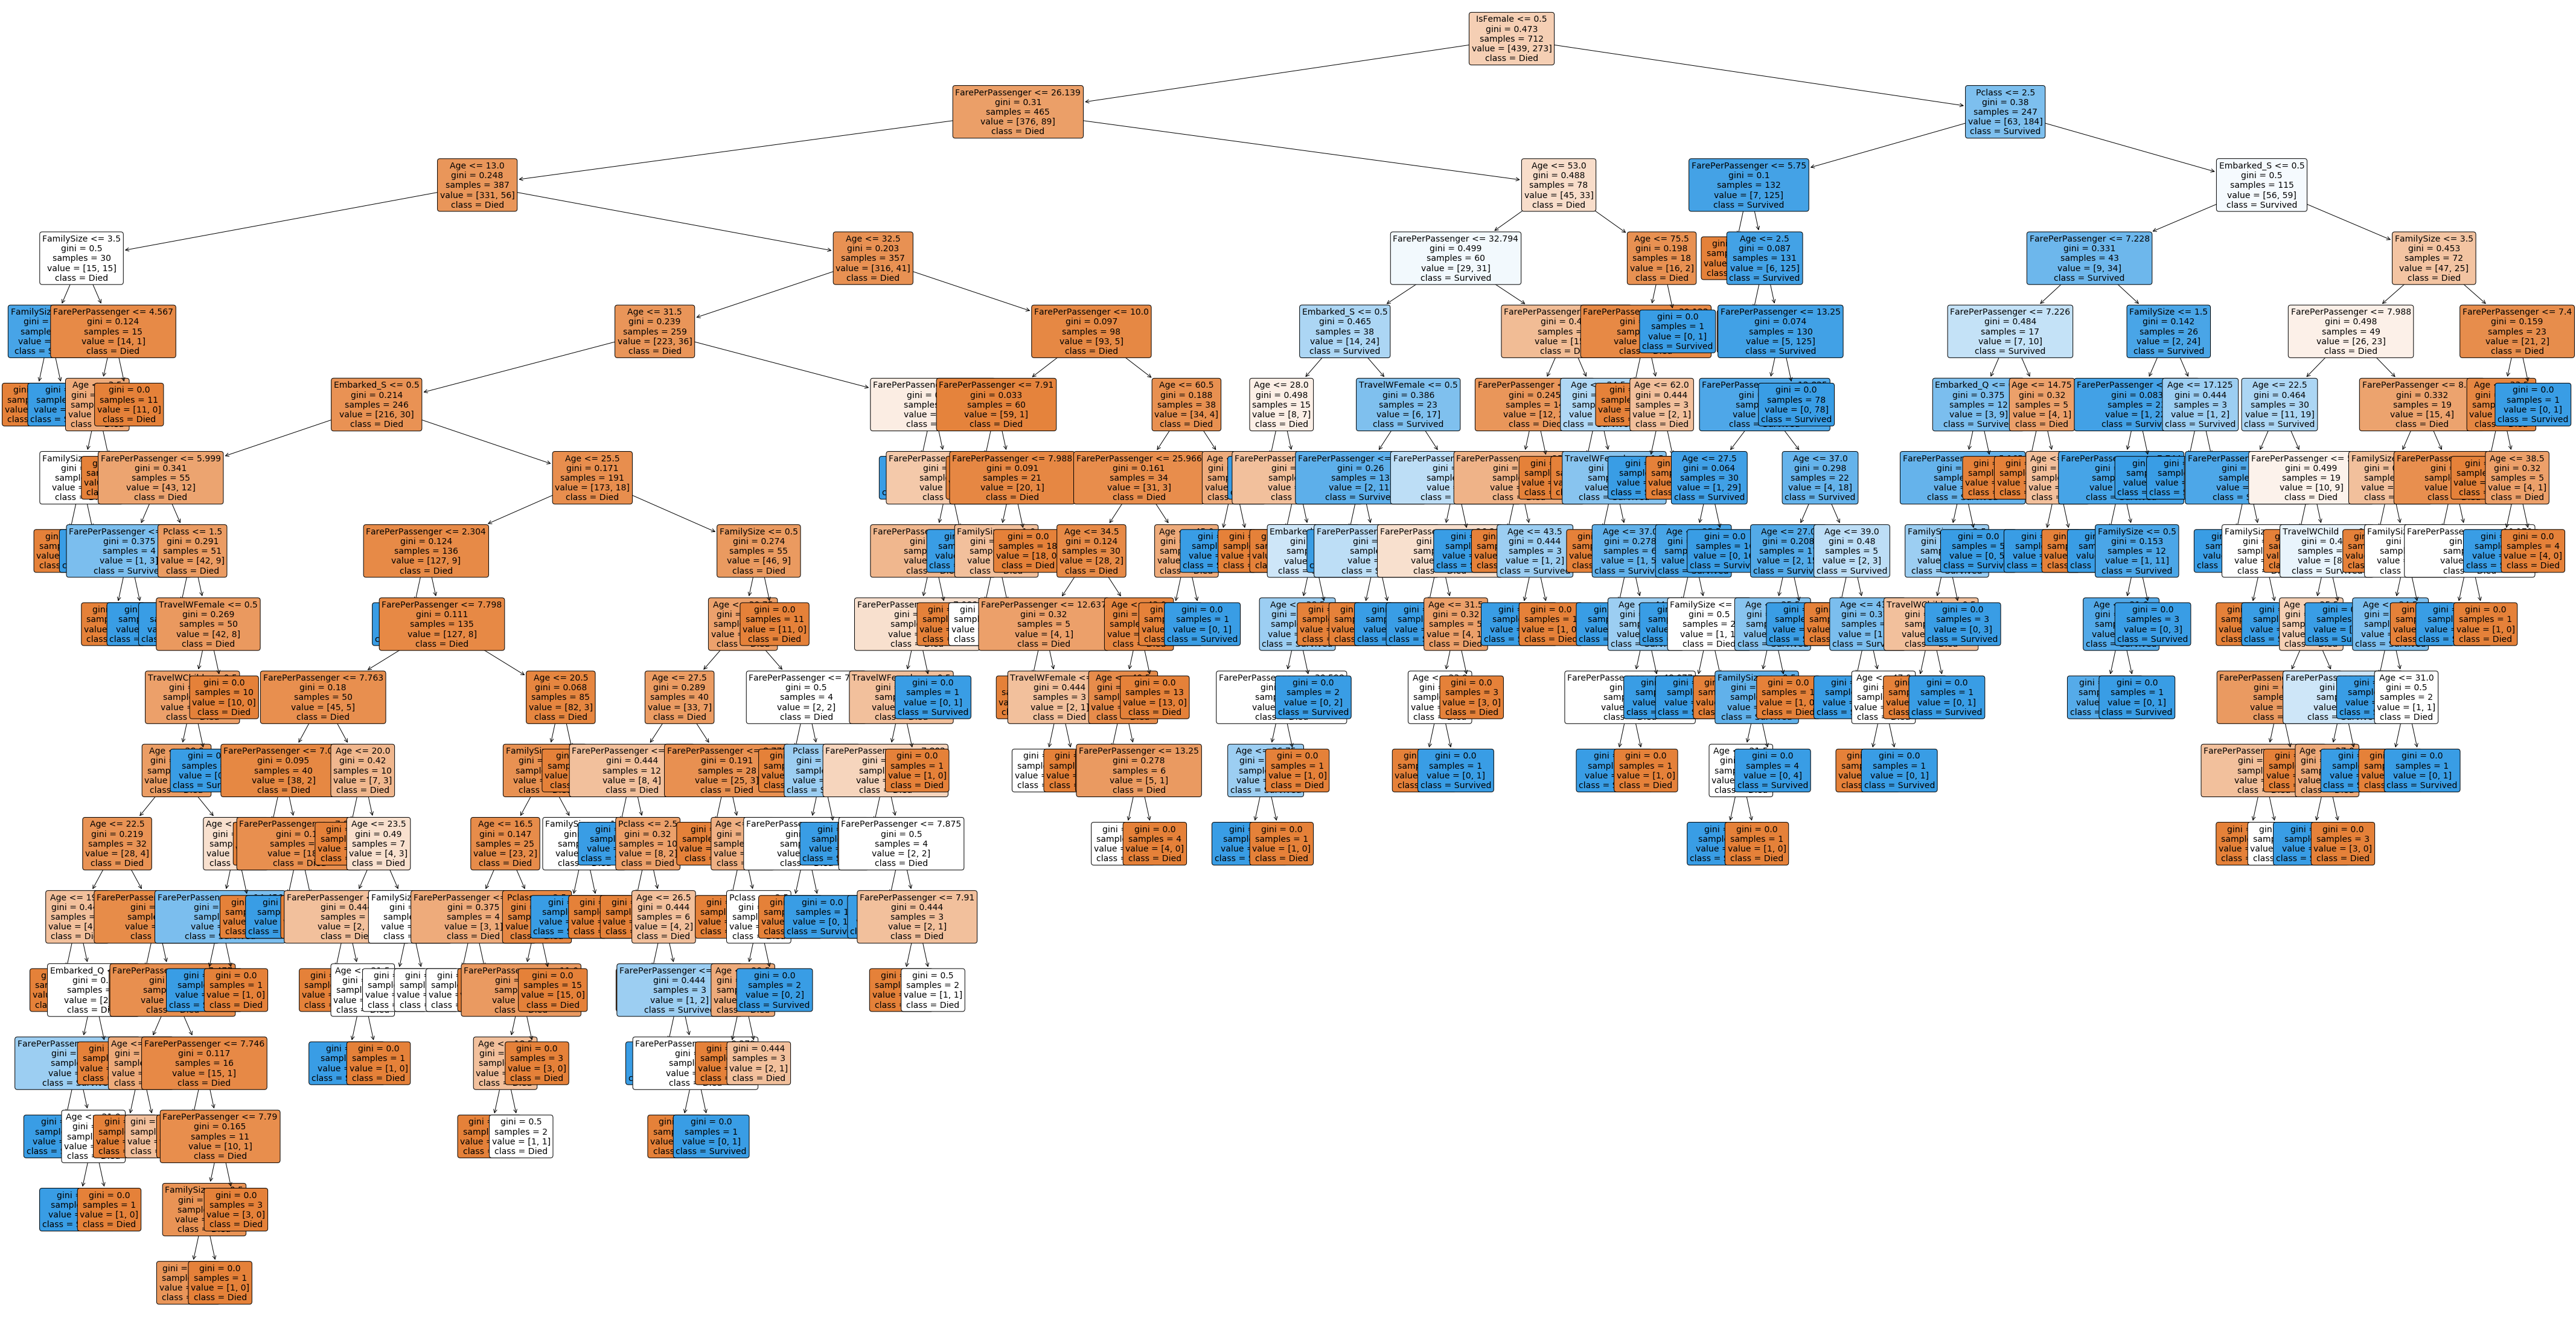

In [105]:
plt.figure(figsize=(75,40))
a = plot_tree(tree_1, 
              feature_names=dec_tree_training.iloc[:,1:].columns, 
              class_names={0:'Died',1:'Survived'},
              filled=True, 
              rounded=True, 
              fontsize=14)

The tree that results is unexplainable and not easy to understand.It's important to optimize this decision tree by pruning so that it doesn't overfit and is easier to understand. 

A few ways to optimize decision tree performance are adjusting the following metrics:
* Criterion: The default is set to 'gini'. This parameter allows us to use different-different attribute selection measure. Supported criteria are 'gini' for the Gini Index and entropy for the information gain. Gini and entropy tend to perform similarly, but gini is less computationally intensive.
* Splitter: The default is set to 'best'. This parameter allows us to choose the split strategy. Supported strategies are 'best' to choose the best split and 'random' to choose the best random split
* max_depth: The default is set to 'None'. This defines the maximum depth of a tree. If None, the nodes are expanded until all the leaves contain less than min_samples_split samples. The higher value of maximum depth causes overfitting and a lower value causes underfitting. If not set to a limit, the decision tree will split until all leaves are pure or until all leaves contain less than the min_samples_split samples
* min_samples_split: The default is set to two. Defines the minimum number of samples required to split an internal node. 

In [106]:
max_depths = list(range(1,41))
min_samples_leaves = list(range(1,41))

In [107]:
# cv = 5 means five fold cross validation, n_jobs = -1 enables it to use all available processors, will run all combinations and permutations of max_depths from 1 to 40 and min_samples_leaves from 1 to 40

In [108]:
grid_decision_tree = GridSearchCV(DecisionTreeClassifier(),{'max_depth': max_depths, 'min_samples_leaf': min_samples_leaves}, cv = 5,scoring = 'roc_auc', n_jobs = -1)

In [109]:
grid_decision_tree.fit(X, y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20, 21, 22, 23, 24, 25, 26, 27,
                                              28, 29, 30, ...]},
             scoring='roc_auc')

In [110]:
grid_decision_tree.best_score_

0.858698252735478

In [111]:
grid_decision_tree.best_params_

{'max_depth': 11, 'min_samples_leaf': 24}

In [112]:
grid_decision_tree.best_params_['max_depth']

11

In [113]:
pd.DataFrame(grid_decision_tree.cv_results_).sort_values(by = ['mean_test_score'], ascending = False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1583,0.001999,1.094321e-03,0.001799,7.477551e-04,40,24,"{'max_depth': 40, 'min_samples_leaf': 24}",0.772332,0.866578,0.892380,0.866377,0.895825,0.858698,0.044929,1
783,0.001599,4.896303e-04,0.001799,3.989225e-04,20,24,"{'max_depth': 20, 'min_samples_leaf': 24}",0.772332,0.866578,0.892380,0.866377,0.895825,0.858698,0.044929,1
463,0.001399,4.891821e-04,0.001799,3.995897e-04,12,24,"{'max_depth': 12, 'min_samples_leaf': 24}",0.772332,0.866578,0.892380,0.866377,0.895825,0.858698,0.044929,1
703,0.001400,4.898240e-04,0.001798,3.988983e-04,18,24,"{'max_depth': 18, 'min_samples_leaf': 24}",0.772332,0.866578,0.892380,0.866377,0.895825,0.858698,0.044929,1
1063,0.001600,4.895710e-04,0.001599,4.894149e-04,27,24,"{'max_depth': 27, 'min_samples_leaf': 24}",0.772332,0.866578,0.892380,0.866377,0.895825,0.858698,0.044929,1
743,0.001599,4.894539e-04,0.001599,4.895712e-04,19,24,"{'max_depth': 19, 'min_samples_leaf': 24}",0.772332,0.866578,0.892380,0.866377,0.895825,0.858698,0.044929,1
1503,0.001400,4.901546e-04,0.001598,4.904270e-04,38,24,"{'max_depth': 38, 'min_samples_leaf': 24}",0.772332,0.866578,0.892380,0.866377,0.895825,0.858698,0.044929,1
1263,0.001599,4.894345e-04,0.001599,4.895707e-04,32,24,"{'max_depth': 32, 'min_samples_leaf': 24}",0.772332,0.866578,0.892380,0.866377,0.895825,0.858698,0.044929,1
1543,0.001399,4.895513e-04,0.001599,4.894927e-04,39,24,"{'max_depth': 39, 'min_samples_leaf': 24}",0.772332,0.866578,0.892380,0.866377,0.895825,0.858698,0.044929,1
943,0.001399,4.893369e-04,0.003798,4.619242e-03,24,24,"{'max_depth': 24, 'min_samples_leaf': 24}",0.772332,0.866578,0.892380,0.866377,0.895825,0.858698,0.044929,1


In [114]:
tree_2 = DecisionTreeClassifier(max_depth = grid_decision_tree.best_params_['max_depth'], min_samples_leaf = grid_decision_tree.best_params_['min_samples_leaf'])
tree_2 = tree_2.fit(X_train, y_train)
y_pred = tree_2.predict(X_test)

In [115]:
cm = confusion_matrix(y_test, y_pred)

In [116]:
print(cm)
print('---------------------------------------')
print('Precision: ' + str(precision_score(y_test, y_pred)))
print('Recall: ' + str(recall_score(y_test, y_pred)))
print('F1 Score: ' + str(f1_score(y_test, y_pred)))

[[92 18]
 [23 46]]
---------------------------------------
Precision: 0.71875
Recall: 0.6666666666666666
F1 Score: 0.6917293233082707


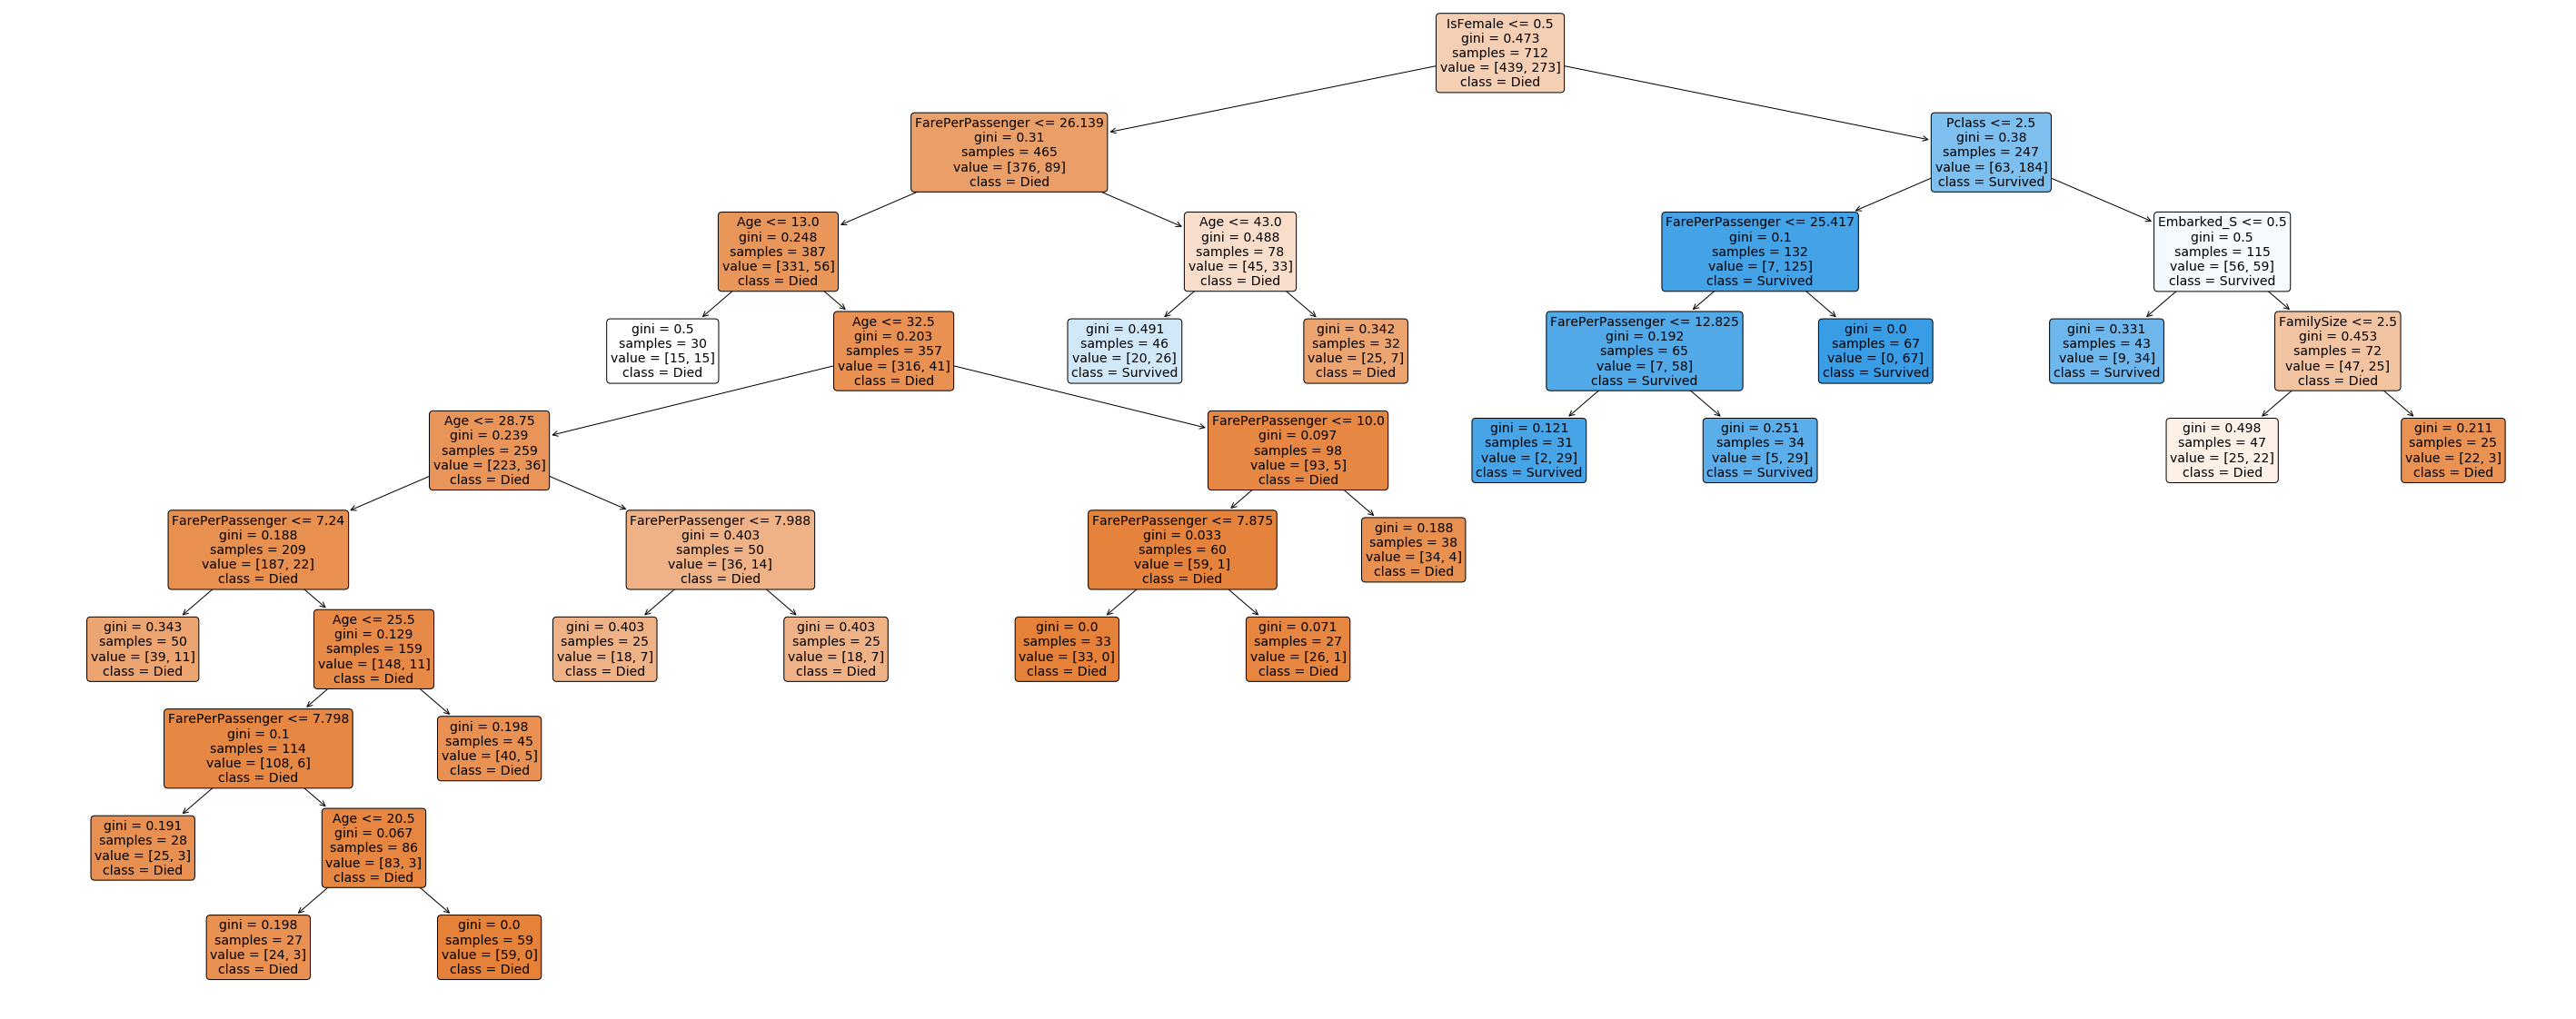

In [117]:
plt.figure(figsize=(50,20))
a = plot_tree(tree_2, 
              feature_names=dec_tree_training.iloc[:,1:].columns, 
              class_names={0:'Died',1:'Survived'},
              filled=True, 
              rounded=True, 
              fontsize=14)
plt.savefig('02-images/decision_tree_2.pdf')

Decision trees often suffer from high variance. This means that if we split training data into two parts at random and fit a decision tree to both halves, the results that we get could be quite different.

Random forests builds a number of decision trees. When building these decision trees, each time a split in a tree is considered, a random sample of m predictors is chosen as split candidates from the full set of p predictors. A fresh sample of m predictors is taken at each split. The number of predictors considered at each split is approximately equal to the square root of the total number of predictors. The split is only allowed to use one of those m predictors. Random forests force each split to consider only a subset of the predictors.

The rationale for why random forests function this way is that it prevents the bagged decision trees used in a random forest from being highly correlated to each other. For example, if the dataset being used has one very strong predictor then most or all of the trees will use this strong predictor in the top split. Consequently, all of the bagged trees will look very similar to each other. The downside of having many similar predictors is that when they're averaged, it does not lead to as large a variance reduction as it would if it were averaging many uncorrelated predictors.

In [118]:
rndm_frst_training = training_data_cleaned.copy()

In [119]:
rndm_frst_training.drop(columns = ['Cabin','SibSp', 'Parch', 'WithFamily','Name', 'Ticket','Sex', 'ChildAdult','TicketCount','NumberOfChildren', 'NumberOfFemales', 'Fare', 'IsChild'], inplace = True)

In [120]:
rndm_frst_training.columns

Index(['Survived', 'Pclass', 'Age', 'Embarked', 'FamilySize', 'IsFemale',
       'TravelWChild', 'TravelWFemale', 'FarePerPassenger'],
      dtype='object')

In [121]:
rndm_frst_training = pd.get_dummies(rndm_frst_training, columns = ['Embarked'], drop_first = True)

In [122]:
rndm_frst_training.head()

,Survived,Pclass,Age,FamilySize,IsFemale,TravelWChild,TravelWFemale,FarePerPassenger,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,0,0,7.25000,0,1
1,1,1,38.0,1,1,0,0,35.64165,0,0
2,1,3,26.0,0,1,0,0,7.92500,0,1
3,1,1,35.0,1,1,0,0,26.55000,0,1
4,0,1,37.0,1,0,0,1,26.55000,0,1


In [123]:
y = rndm_frst_training.iloc[:,0].values
X = rndm_frst_training.iloc[:,1:].values

In [124]:
n_estimators = list(range(1,126))
max_depths = list(range(1,34))
min_samples_splits = list(range(1,34))
min_samples_leaves = list(range(1,34))

In [125]:
grid_random_forest = RandomizedSearchCV(RandomForestClassifier(),{'n_estimators':n_estimators, 'max_depth': max_depths, 'min_samples_leaf': min_samples_leaves, 'min_samples_split': min_samples_splits}, cv = 5,scoring = 'roc_auc', n_iter = 25, n_jobs = -1, random_state = 0)

In [126]:
grid_random_forest.fit(X, y)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=25,
                   n_jobs=-1,
                   param_distributions={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29, 30, ...],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15, 16,
                                                             17, 18, 19, 20, 21,
                                                             22, 23, 24, 25, 26,
                                                             27, 28, 29, 30, ...],
                            

In [127]:
grid_random_forest.best_score_

0.8581376175229855

In [128]:
grid_random_forest.best_params_

{'n_estimators': 34,
 'min_samples_split': 7,
 'min_samples_leaf': 4,
 'max_depth': 18}

In [129]:
grid_random_forest.best_params_['n_estimators']

34

In [130]:
grid_random_forest.best_params_['max_depth']

18

In [131]:
grid_random_forest.best_params_['min_samples_leaf']

4

In [132]:
grid_random_forest.best_params_['min_samples_split']

7

In [133]:
pd.DataFrame(grid_random_forest.cv_results_).sort_values(by = ['mean_test_score'], ascending = False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
23,0.061964,0.001413,0.008196,1.468517e-03,34,7,4,18,"{'n_estimators': 34, 'min_samples_split': 7, '...",0.778195,0.869652,0.885361,0.865976,0.891504,0.858138,0.041083,1
3,0.184894,0.005963,0.018990,6.320327e-04,107,4,11,17,"{'n_estimators': 107, 'min_samples_split': 4, ...",0.759223,0.858757,0.887901,0.860628,0.902141,0.853730,0.050031,2
7,0.106939,0.004379,0.012792,3.122390e-03,63,32,12,25,"{'n_estimators': 63, 'min_samples_split': 32, ...",0.761199,0.852072,0.883957,0.869385,0.895626,0.852448,0.047897,3
17,0.046973,0.003345,0.006996,1.547665e-03,27,15,17,28,"{'n_estimators': 27, 'min_samples_split': 15, ...",0.753887,0.845120,0.891310,0.863436,0.904467,0.851644,0.053107,4
21,0.167504,0.003260,0.017590,4.897459e-04,100,2,15,11,"{'n_estimators': 100, 'min_samples_split': 2, ...",0.758762,0.850468,0.883021,0.862299,0.902407,0.851391,0.049605,5
6,0.202684,0.005525,0.020988,1.548466e-03,120,11,10,3,"{'n_estimators': 120, 'min_samples_split': 11,...",0.758169,0.854011,0.888302,0.865107,0.888778,0.850873,0.048258,6
22,0.142319,0.002496,0.015191,3.993754e-04,85,28,3,5,"{'n_estimators': 85, 'min_samples_split': 28, ...",0.756917,0.855548,0.886765,0.856885,0.896756,0.850574,0.049555,7
2,0.154111,0.005189,0.016391,4.896094e-04,93,11,18,17,"{'n_estimators': 93, 'min_samples_split': 11, ...",0.757510,0.841243,0.886898,0.861898,0.902407,0.849991,0.050756,8
11,0.199686,0.006582,0.021387,2.937475e-03,121,3,16,5,"{'n_estimators': 121, 'min_samples_split': 3, ...",0.753623,0.852072,0.884091,0.860628,0.898883,0.849860,0.050907,9
14,0.189291,0.005532,0.022188,2.480725e-03,113,28,19,19,"{'n_estimators': 113, 'min_samples_split': 28,...",0.757049,0.845922,0.882487,0.857219,0.904667,0.849469,0.050500,10


In [134]:
scores_logistic_regression = cross_validate(classifier, X_logistic, y_logistic, cv = 5, scoring = ['precision', 'recall', 'f1', 'roc_auc'])

In [135]:
print('Logistic Regression Test Results')
print('precision score: ' + str(scores_logistic_regression['test_precision'].mean()))
print('recall score: ' + str(scores_logistic_regression['test_recall'].mean()))
print('f1 score: ' + str(scores_logistic_regression['test_f1'].mean()))
print('AUC Score: '+ str(scores_logistic_regression['test_roc_auc'].mean()))

Logistic Regression Test Results
precision score: 0.7458676896819452
recall score: 0.7020886615515771
f1 score: 0.7177232594826926
AUC Score: 0.844523092915594


In [136]:
scores_decision_tree = cross_validate(tree_2, X, y, cv = 5, scoring = ['precision', 'recall', 'f1', 'roc_auc'])

In [137]:
print('Decision Tree Test Results')
print('precision score: ' + str(scores_decision_tree['test_precision'].mean()))
print('recall score: ' + str(scores_decision_tree['test_recall'].mean()))
print('f1 score: ' + str(scores_decision_tree['test_f1'].mean()))
print('AUC Score: '+ str(scores_decision_tree['test_roc_auc'].mean()))

Decision Tree Test Results
precision score: 0.7788130363280593
recall score: 0.6933503836317136
f1 score: 0.7234376138409261
AUC Score: 0.858698252735478


In [138]:
forrest_1 = RandomForestClassifier(random_state = 0, max_features = 3, n_estimators = grid_random_forest.best_params_['n_estimators'], max_depth = grid_random_forest.best_params_['max_depth'], min_samples_leaf = grid_random_forest.best_params_['min_samples_leaf'], min_samples_split = grid_random_forest.best_params_['min_samples_split'])

In [139]:
scores_random_forest = cross_validate(forrest_1, X, y, cv = 5, scoring = ['precision', 'recall', 'f1', 'roc_auc'])

In [140]:
print(scores_random_forest)

{'fit_time': array([0.0569694 , 0.04197645, 0.03997731, 0.0399766 , 0.0399766 ]), 'score_time': array([0.01398945, 0.01099396, 0.01099324, 0.0109942 , 0.01099372]), 'test_precision': array([0.65217391, 0.81967213, 0.75641026, 0.90384615, 0.82      ]), 'test_recall': array([0.65217391, 0.73529412, 0.86764706, 0.69117647, 0.5942029 ]), 'test_f1': array([0.65217391, 0.7751938 , 0.80821918, 0.78333333, 0.68907563]), 'test_roc_auc': array([0.77081686, 0.87092246, 0.89772727, 0.86510695, 0.87721048])}


In [141]:
print('Random Forest Test Results')
print('precision score: ' + str(scores_random_forest['test_precision'].mean()))
print('recall score: ' + str(scores_random_forest['test_recall'].mean()))
print('f1 score: ' + str(scores_random_forest['test_f1'].mean()))
print('AUC Score: '+ str(scores_random_forest['test_roc_auc'].mean()))

Random Forest Test Results
precision score: 0.7904204908894858
recall score: 0.7080988917306053
f1 score: 0.7415991706321433
AUC Score: 0.8563568052234493
